In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

# 导入数据集

In [2]:
slammer_df = pd.read_csv("./dataset/slammer.csv")
slammer_df = slammer_df.drop(columns="Hour and Minutes")

In [63]:
# slammer_df

# 生成datetime属性

In [4]:
slammer_df['date'] = slammer_df["Hour"].astype("str") + "+" + slammer_df["Minutes"].astype("str") + "+" + slammer_df["Seconds"].astype("str")

In [5]:
slammer_df["datetime"] = pd.to_datetime(slammer_df["date"],format='%H+%M+%S')

In [6]:
slammer_df = slammer_df.drop(columns="date")

In [98]:
columns_names = slammer_df.columns
columns_number = slammer_df.columns.shape[0]
COLUMNS = []
for i in range(0,columns_number):
    COLUMNS.append(columns_names[i])
COLUMNS = COLUMNS[3:]
COLUMNS = COLUMNS[:-1]

# 去除Hour Minute Second三列后，取37列属性进行训练

In [100]:
COLUMNS_train = ["Number of announcements","Number of withdrawals","Number of announced NLRI prefixes","Average AS-path length","Maximum AS-path length","Average unique AS-path length"]
COLUMNS_announcements = ["Number of announcements"]

COLUMNS_BIG = ["Number of announcements","Number of announced NLRI prefixes"]
COLUMNS_SMALL = ["Number of withdrawals","Average AS-path length","Maximum AS-path length","Average unique AS-path length"]

In [103]:
slammer_df_train = slammer_df[['datetime'] + COLUMNS]

In [104]:
slammer_df_train

,datetime,Number of announcements,Number of withdrawals,Number of announced NLRI prefixes,Number of withdrawn NLRI prefixes,Average AS-path length,Maximum AS-path length,Average unique AS-path length,Number of duplicate announcements,Number of duplicate withdrawals,...,Maximum AS-path length11,Maximum AS-path length12,Maximum AS-path length13,Maximum AS-path length14,Maximum AS-path length15,Number of Interior Gateway Protocol (IGP) packets,Number of Exterior Gateway Protocol (EGP) packets,Number of incomplete packets,Packet size (B),Label
0,1900-01-01 00:01:04,40,4,161,28,6,8,6,27,96,...,0,0,0,0,0,34,0,6,287,-1
1,1900-01-01 00:02:00,59,7,133,69,6,13,6,2,103,...,0,1,0,0,0,55,0,4,256,-1
2,1900-01-01 00:03:12,52,4,138,32,5,7,6,12,105,...,0,0,0,0,0,48,0,4,263,-1
3,1900-01-01 00:04:09,49,2,119,24,6,9,6,1,63,...,0,0,0,0,0,46,0,3,252,-1
4,1900-01-01 00:05:04,80,3,231,26,7,11,7,8,228,...,0,0,0,0,0,76,0,4,270,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,1900-01-01 23:55:15,44,5,90,21,6,18,6,13,58,...,0,0,0,0,0,39,0,5,243,-1
7195,1900-01-01 23:56:13,21,1,39,1,6,11,6,0,13,...,0,0,0,0,0,18,0,3,222,-1
7196,1900-01-01 23:57:07,17,3,49,6,6,11,6,0,11,...,0,0,0,0,0,16,0,1,241,-1
7197,1900-01-01 23:58:03,27,5,58,7,6,19,6,4,19,...,0,0,0,0,0,20,0,7,223,-1


# 选出Label=1的记录(异常记录)，进行训练

In [105]:
slammer_df_train = slammer_df_train[slammer_df_train["Label"]==1]

In [66]:
# slammer_df_train

In [106]:
slammer_df_train = slammer_df_train.drop(columns="Label")

In [107]:
print(slammer_df_train.shape)

(869, 38)


# 画图看一下训练前数据的分布情况

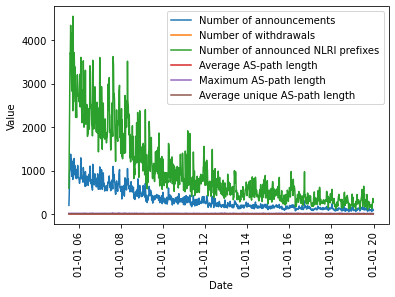

In [110]:
for c in COLUMNS_train:
    plt.plot(slammer_df_train["datetime"], slammer_df_train[c], label=c)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Value")
plt.xlabel("Date")
plt.show()

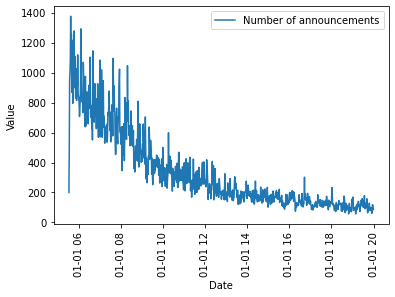

In [111]:
for c in COLUMNS_announcements:
    plt.plot(slammer_df_train["datetime"], slammer_df_train[c], label=c)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Value")
plt.xlabel("Date")
plt.show()

In [112]:
features = slammer_df_train.drop(columns="datetime").to_numpy()

In [113]:
features.shape

(869, 37)

In [114]:
# Obsevations every 10 minutes, so 144 * 10 minutes = 1 day
n = features.shape[0] // 60
features = features[:(n*60),:].reshape(-1, 60, features.shape[1])
# Shape is now (# examples, # time points, # features)
print(features.shape)

(14, 60, 37)


# 画图展示原始数据(取1小时的数据为例)
## 将 数值大的属性 和 数值小的属性 分开画图展示，不然看不清楚

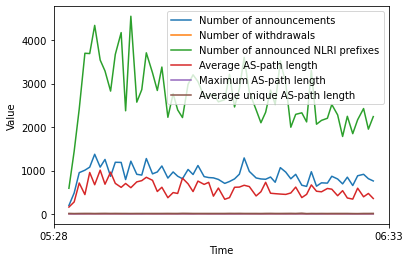

In [115]:
xaxis_1day = slammer_df_train["datetime"][0:60]

def plot_day(f):
    for i, c in enumerate(COLUMNS_train):
        plt.plot(xaxis_1day, f[:,i], label=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(2,24,3)))
    ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

plot_day(features[0,:,:])

In [22]:
torch.cuda.is_available()

True

# 配置中选择离散特征进行训练

In [121]:
features.shape[2]

37

In [116]:
%%capture

# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=3,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

model.train_numpy(
    features,
    feature_types = [OutputType.DISCRETE] * features.shape[2],
)

# Generate synthetic data
_, synthetic_features = model.generate_numpy(1000)

2022-09-14 09:09:52,990 : MainThread : INFO : epoch: 0
2022-09-14 09:09:57,855 : MainThread : INFO : epoch: 1
2022-09-14 09:09:58,427 : MainThread : INFO : epoch: 2
2022-09-14 09:09:58,917 : MainThread : INFO : epoch: 3
2022-09-14 09:09:59,381 : MainThread : INFO : epoch: 4
2022-09-14 09:09:59,843 : MainThread : INFO : epoch: 5
2022-09-14 09:10:00,307 : MainThread : INFO : epoch: 6
2022-09-14 09:10:00,777 : MainThread : INFO : epoch: 7
2022-09-14 09:10:01,242 : MainThread : INFO : epoch: 8
2022-09-14 09:10:01,707 : MainThread : INFO : epoch: 9
2022-09-14 09:10:02,172 : MainThread : INFO : epoch: 10
2022-09-14 09:10:02,637 : MainThread : INFO : epoch: 11
2022-09-14 09:10:03,103 : MainThread : INFO : epoch: 12
2022-09-14 09:10:03,567 : MainThread : INFO : epoch: 13
2022-09-14 09:10:04,032 : MainThread : INFO : epoch: 14
2022-09-14 09:10:04,496 : MainThread : INFO : epoch: 15
2022-09-14 09:10:04,965 : MainThread : INFO : epoch: 16
2022-09-14 09:10:05,430 : MainThread : INFO : epoch: 17
20

2022-09-14 09:11:05,416 : MainThread : INFO : epoch: 146
2022-09-14 09:11:05,882 : MainThread : INFO : epoch: 147
2022-09-14 09:11:06,348 : MainThread : INFO : epoch: 148
2022-09-14 09:11:06,812 : MainThread : INFO : epoch: 149
2022-09-14 09:11:07,278 : MainThread : INFO : epoch: 150
2022-09-14 09:11:07,743 : MainThread : INFO : epoch: 151
2022-09-14 09:11:08,209 : MainThread : INFO : epoch: 152
2022-09-14 09:11:08,675 : MainThread : INFO : epoch: 153
2022-09-14 09:11:09,140 : MainThread : INFO : epoch: 154
2022-09-14 09:11:09,607 : MainThread : INFO : epoch: 155
2022-09-14 09:11:10,071 : MainThread : INFO : epoch: 156
2022-09-14 09:11:10,537 : MainThread : INFO : epoch: 157
2022-09-14 09:11:11,002 : MainThread : INFO : epoch: 158
2022-09-14 09:11:11,466 : MainThread : INFO : epoch: 159
2022-09-14 09:11:11,933 : MainThread : INFO : epoch: 160
2022-09-14 09:11:12,397 : MainThread : INFO : epoch: 161
2022-09-14 09:11:12,863 : MainThread : INFO : epoch: 162
2022-09-14 09:11:13,329 : MainT

2022-09-14 09:12:12,433 : MainThread : INFO : epoch: 290
2022-09-14 09:12:12,899 : MainThread : INFO : epoch: 291
2022-09-14 09:12:13,366 : MainThread : INFO : epoch: 292
2022-09-14 09:12:13,832 : MainThread : INFO : epoch: 293
2022-09-14 09:12:14,298 : MainThread : INFO : epoch: 294
2022-09-14 09:12:14,763 : MainThread : INFO : epoch: 295
2022-09-14 09:12:15,228 : MainThread : INFO : epoch: 296
2022-09-14 09:12:15,693 : MainThread : INFO : epoch: 297
2022-09-14 09:12:16,158 : MainThread : INFO : epoch: 298
2022-09-14 09:12:16,622 : MainThread : INFO : epoch: 299
2022-09-14 09:12:17,087 : MainThread : INFO : epoch: 300
2022-09-14 09:12:17,552 : MainThread : INFO : epoch: 301
2022-09-14 09:12:18,018 : MainThread : INFO : epoch: 302
2022-09-14 09:12:18,483 : MainThread : INFO : epoch: 303
2022-09-14 09:12:18,947 : MainThread : INFO : epoch: 304
2022-09-14 09:12:19,413 : MainThread : INFO : epoch: 305
2022-09-14 09:12:19,878 : MainThread : INFO : epoch: 306
2022-09-14 09:12:20,343 : MainT

2022-09-14 09:13:19,475 : MainThread : INFO : epoch: 434
2022-09-14 09:13:19,940 : MainThread : INFO : epoch: 435
2022-09-14 09:13:20,406 : MainThread : INFO : epoch: 436
2022-09-14 09:13:20,870 : MainThread : INFO : epoch: 437
2022-09-14 09:13:21,336 : MainThread : INFO : epoch: 438
2022-09-14 09:13:21,801 : MainThread : INFO : epoch: 439
2022-09-14 09:13:22,267 : MainThread : INFO : epoch: 440
2022-09-14 09:13:22,731 : MainThread : INFO : epoch: 441
2022-09-14 09:13:23,199 : MainThread : INFO : epoch: 442
2022-09-14 09:13:23,665 : MainThread : INFO : epoch: 443
2022-09-14 09:13:24,131 : MainThread : INFO : epoch: 444
2022-09-14 09:13:24,599 : MainThread : INFO : epoch: 445
2022-09-14 09:13:25,066 : MainThread : INFO : epoch: 446
2022-09-14 09:13:25,533 : MainThread : INFO : epoch: 447
2022-09-14 09:13:25,999 : MainThread : INFO : epoch: 448
2022-09-14 09:13:26,465 : MainThread : INFO : epoch: 449
2022-09-14 09:13:26,930 : MainThread : INFO : epoch: 450
2022-09-14 09:13:27,395 : MainT

2022-09-14 09:14:26,531 : MainThread : INFO : epoch: 578
2022-09-14 09:14:26,997 : MainThread : INFO : epoch: 579
2022-09-14 09:14:27,463 : MainThread : INFO : epoch: 580
2022-09-14 09:14:27,928 : MainThread : INFO : epoch: 581
2022-09-14 09:14:28,394 : MainThread : INFO : epoch: 582
2022-09-14 09:14:28,859 : MainThread : INFO : epoch: 583
2022-09-14 09:14:29,324 : MainThread : INFO : epoch: 584
2022-09-14 09:14:29,789 : MainThread : INFO : epoch: 585
2022-09-14 09:14:30,254 : MainThread : INFO : epoch: 586
2022-09-14 09:14:30,719 : MainThread : INFO : epoch: 587
2022-09-14 09:14:31,185 : MainThread : INFO : epoch: 588
2022-09-14 09:14:31,651 : MainThread : INFO : epoch: 589
2022-09-14 09:14:32,116 : MainThread : INFO : epoch: 590
2022-09-14 09:14:32,582 : MainThread : INFO : epoch: 591
2022-09-14 09:14:33,047 : MainThread : INFO : epoch: 592
2022-09-14 09:14:33,513 : MainThread : INFO : epoch: 593
2022-09-14 09:14:33,979 : MainThread : INFO : epoch: 594
2022-09-14 09:14:34,445 : MainT

2022-09-14 09:15:33,609 : MainThread : INFO : epoch: 722
2022-09-14 09:15:34,076 : MainThread : INFO : epoch: 723
2022-09-14 09:15:34,541 : MainThread : INFO : epoch: 724
2022-09-14 09:15:35,006 : MainThread : INFO : epoch: 725
2022-09-14 09:15:35,472 : MainThread : INFO : epoch: 726
2022-09-14 09:15:35,937 : MainThread : INFO : epoch: 727
2022-09-14 09:15:36,403 : MainThread : INFO : epoch: 728
2022-09-14 09:15:36,869 : MainThread : INFO : epoch: 729
2022-09-14 09:15:37,334 : MainThread : INFO : epoch: 730
2022-09-14 09:15:37,800 : MainThread : INFO : epoch: 731
2022-09-14 09:15:38,266 : MainThread : INFO : epoch: 732
2022-09-14 09:15:38,732 : MainThread : INFO : epoch: 733
2022-09-14 09:15:39,198 : MainThread : INFO : epoch: 734
2022-09-14 09:15:39,663 : MainThread : INFO : epoch: 735
2022-09-14 09:15:40,129 : MainThread : INFO : epoch: 736
2022-09-14 09:15:40,596 : MainThread : INFO : epoch: 737
2022-09-14 09:15:41,063 : MainThread : INFO : epoch: 738
2022-09-14 09:15:41,527 : MainT

2022-09-14 09:16:40,686 : MainThread : INFO : epoch: 866
2022-09-14 09:16:41,152 : MainThread : INFO : epoch: 867
2022-09-14 09:16:41,617 : MainThread : INFO : epoch: 868
2022-09-14 09:16:42,082 : MainThread : INFO : epoch: 869
2022-09-14 09:16:42,549 : MainThread : INFO : epoch: 870
2022-09-14 09:16:43,016 : MainThread : INFO : epoch: 871
2022-09-14 09:16:43,481 : MainThread : INFO : epoch: 872
2022-09-14 09:16:43,946 : MainThread : INFO : epoch: 873
2022-09-14 09:16:44,412 : MainThread : INFO : epoch: 874
2022-09-14 09:16:44,876 : MainThread : INFO : epoch: 875
2022-09-14 09:16:45,343 : MainThread : INFO : epoch: 876
2022-09-14 09:16:45,808 : MainThread : INFO : epoch: 877
2022-09-14 09:16:46,274 : MainThread : INFO : epoch: 878
2022-09-14 09:16:46,738 : MainThread : INFO : epoch: 879
2022-09-14 09:16:47,206 : MainThread : INFO : epoch: 880
2022-09-14 09:16:47,671 : MainThread : INFO : epoch: 881
2022-09-14 09:16:48,137 : MainThread : INFO : epoch: 882
2022-09-14 09:16:48,602 : MainT

2022-09-14 09:17:47,749 : MainThread : INFO : epoch: 1010
2022-09-14 09:17:48,215 : MainThread : INFO : epoch: 1011
2022-09-14 09:17:48,681 : MainThread : INFO : epoch: 1012
2022-09-14 09:17:49,147 : MainThread : INFO : epoch: 1013
2022-09-14 09:17:49,612 : MainThread : INFO : epoch: 1014
2022-09-14 09:17:50,077 : MainThread : INFO : epoch: 1015
2022-09-14 09:17:50,543 : MainThread : INFO : epoch: 1016
2022-09-14 09:17:51,008 : MainThread : INFO : epoch: 1017
2022-09-14 09:17:51,474 : MainThread : INFO : epoch: 1018
2022-09-14 09:17:51,939 : MainThread : INFO : epoch: 1019
2022-09-14 09:17:52,405 : MainThread : INFO : epoch: 1020
2022-09-14 09:17:52,871 : MainThread : INFO : epoch: 1021
2022-09-14 09:17:53,337 : MainThread : INFO : epoch: 1022
2022-09-14 09:17:53,803 : MainThread : INFO : epoch: 1023
2022-09-14 09:17:54,268 : MainThread : INFO : epoch: 1024
2022-09-14 09:17:54,732 : MainThread : INFO : epoch: 1025
2022-09-14 09:17:55,198 : MainThread : INFO : epoch: 1026
2022-09-14 09:

2022-09-14 09:18:53,877 : MainThread : INFO : epoch: 1152
2022-09-14 09:18:54,344 : MainThread : INFO : epoch: 1153
2022-09-14 09:18:54,809 : MainThread : INFO : epoch: 1154
2022-09-14 09:18:55,274 : MainThread : INFO : epoch: 1155
2022-09-14 09:18:55,739 : MainThread : INFO : epoch: 1156
2022-09-14 09:18:56,204 : MainThread : INFO : epoch: 1157
2022-09-14 09:18:56,670 : MainThread : INFO : epoch: 1158
2022-09-14 09:18:57,136 : MainThread : INFO : epoch: 1159
2022-09-14 09:18:57,603 : MainThread : INFO : epoch: 1160
2022-09-14 09:18:58,069 : MainThread : INFO : epoch: 1161
2022-09-14 09:18:58,535 : MainThread : INFO : epoch: 1162
2022-09-14 09:18:59,001 : MainThread : INFO : epoch: 1163
2022-09-14 09:18:59,467 : MainThread : INFO : epoch: 1164
2022-09-14 09:18:59,933 : MainThread : INFO : epoch: 1165
2022-09-14 09:19:00,398 : MainThread : INFO : epoch: 1166
2022-09-14 09:19:00,864 : MainThread : INFO : epoch: 1167
2022-09-14 09:19:01,331 : MainThread : INFO : epoch: 1168
2022-09-14 09:

2022-09-14 09:20:00,029 : MainThread : INFO : epoch: 1294
2022-09-14 09:20:00,495 : MainThread : INFO : epoch: 1295
2022-09-14 09:20:00,962 : MainThread : INFO : epoch: 1296
2022-09-14 09:20:01,427 : MainThread : INFO : epoch: 1297
2022-09-14 09:20:01,892 : MainThread : INFO : epoch: 1298
2022-09-14 09:20:02,357 : MainThread : INFO : epoch: 1299
2022-09-14 09:20:02,823 : MainThread : INFO : epoch: 1300
2022-09-14 09:20:03,287 : MainThread : INFO : epoch: 1301
2022-09-14 09:20:03,754 : MainThread : INFO : epoch: 1302
2022-09-14 09:20:04,218 : MainThread : INFO : epoch: 1303
2022-09-14 09:20:04,684 : MainThread : INFO : epoch: 1304
2022-09-14 09:20:05,151 : MainThread : INFO : epoch: 1305
2022-09-14 09:20:05,617 : MainThread : INFO : epoch: 1306
2022-09-14 09:20:06,081 : MainThread : INFO : epoch: 1307
2022-09-14 09:20:06,546 : MainThread : INFO : epoch: 1308
2022-09-14 09:20:07,012 : MainThread : INFO : epoch: 1309
2022-09-14 09:20:07,478 : MainThread : INFO : epoch: 1310
2022-09-14 09:

2022-09-14 09:21:06,185 : MainThread : INFO : epoch: 1436
2022-09-14 09:21:06,651 : MainThread : INFO : epoch: 1437
2022-09-14 09:21:07,116 : MainThread : INFO : epoch: 1438
2022-09-14 09:21:07,583 : MainThread : INFO : epoch: 1439
2022-09-14 09:21:08,049 : MainThread : INFO : epoch: 1440
2022-09-14 09:21:08,515 : MainThread : INFO : epoch: 1441
2022-09-14 09:21:08,980 : MainThread : INFO : epoch: 1442
2022-09-14 09:21:09,446 : MainThread : INFO : epoch: 1443
2022-09-14 09:21:09,913 : MainThread : INFO : epoch: 1444
2022-09-14 09:21:10,379 : MainThread : INFO : epoch: 1445
2022-09-14 09:21:10,845 : MainThread : INFO : epoch: 1446
2022-09-14 09:21:11,310 : MainThread : INFO : epoch: 1447
2022-09-14 09:21:11,777 : MainThread : INFO : epoch: 1448
2022-09-14 09:21:12,243 : MainThread : INFO : epoch: 1449
2022-09-14 09:21:12,709 : MainThread : INFO : epoch: 1450
2022-09-14 09:21:13,174 : MainThread : INFO : epoch: 1451
2022-09-14 09:21:13,639 : MainThread : INFO : epoch: 1452
2022-09-14 09:

2022-09-14 09:22:12,348 : MainThread : INFO : epoch: 1578
2022-09-14 09:22:12,814 : MainThread : INFO : epoch: 1579
2022-09-14 09:22:13,281 : MainThread : INFO : epoch: 1580
2022-09-14 09:22:13,747 : MainThread : INFO : epoch: 1581
2022-09-14 09:22:14,211 : MainThread : INFO : epoch: 1582
2022-09-14 09:22:14,677 : MainThread : INFO : epoch: 1583
2022-09-14 09:22:15,143 : MainThread : INFO : epoch: 1584
2022-09-14 09:22:15,609 : MainThread : INFO : epoch: 1585
2022-09-14 09:22:16,076 : MainThread : INFO : epoch: 1586
2022-09-14 09:22:16,542 : MainThread : INFO : epoch: 1587
2022-09-14 09:22:17,008 : MainThread : INFO : epoch: 1588
2022-09-14 09:22:17,473 : MainThread : INFO : epoch: 1589
2022-09-14 09:22:17,940 : MainThread : INFO : epoch: 1590
2022-09-14 09:22:18,406 : MainThread : INFO : epoch: 1591
2022-09-14 09:22:18,873 : MainThread : INFO : epoch: 1592
2022-09-14 09:22:19,337 : MainThread : INFO : epoch: 1593
2022-09-14 09:22:19,804 : MainThread : INFO : epoch: 1594
2022-09-14 09:

2022-09-14 09:23:18,519 : MainThread : INFO : epoch: 1720
2022-09-14 09:23:18,985 : MainThread : INFO : epoch: 1721
2022-09-14 09:23:19,451 : MainThread : INFO : epoch: 1722
2022-09-14 09:23:19,916 : MainThread : INFO : epoch: 1723
2022-09-14 09:23:20,382 : MainThread : INFO : epoch: 1724
2022-09-14 09:23:20,849 : MainThread : INFO : epoch: 1725
2022-09-14 09:23:21,316 : MainThread : INFO : epoch: 1726
2022-09-14 09:23:21,781 : MainThread : INFO : epoch: 1727
2022-09-14 09:23:22,247 : MainThread : INFO : epoch: 1728
2022-09-14 09:23:22,713 : MainThread : INFO : epoch: 1729
2022-09-14 09:23:23,179 : MainThread : INFO : epoch: 1730
2022-09-14 09:23:23,647 : MainThread : INFO : epoch: 1731
2022-09-14 09:23:24,114 : MainThread : INFO : epoch: 1732
2022-09-14 09:23:24,580 : MainThread : INFO : epoch: 1733
2022-09-14 09:23:25,047 : MainThread : INFO : epoch: 1734
2022-09-14 09:23:25,514 : MainThread : INFO : epoch: 1735
2022-09-14 09:23:25,979 : MainThread : INFO : epoch: 1736
2022-09-14 09:

2022-09-14 09:24:24,689 : MainThread : INFO : epoch: 1862
2022-09-14 09:24:25,154 : MainThread : INFO : epoch: 1863
2022-09-14 09:24:25,622 : MainThread : INFO : epoch: 1864
2022-09-14 09:24:26,088 : MainThread : INFO : epoch: 1865
2022-09-14 09:24:26,552 : MainThread : INFO : epoch: 1866
2022-09-14 09:24:27,018 : MainThread : INFO : epoch: 1867
2022-09-14 09:24:27,484 : MainThread : INFO : epoch: 1868
2022-09-14 09:24:27,949 : MainThread : INFO : epoch: 1869
2022-09-14 09:24:28,415 : MainThread : INFO : epoch: 1870
2022-09-14 09:24:28,881 : MainThread : INFO : epoch: 1871
2022-09-14 09:24:29,347 : MainThread : INFO : epoch: 1872
2022-09-14 09:24:29,813 : MainThread : INFO : epoch: 1873
2022-09-14 09:24:30,279 : MainThread : INFO : epoch: 1874
2022-09-14 09:24:30,746 : MainThread : INFO : epoch: 1875
2022-09-14 09:24:31,212 : MainThread : INFO : epoch: 1876
2022-09-14 09:24:31,677 : MainThread : INFO : epoch: 1877
2022-09-14 09:24:32,144 : MainThread : INFO : epoch: 1878
2022-09-14 09:

2022-09-14 09:25:30,849 : MainThread : INFO : epoch: 2004
2022-09-14 09:25:31,314 : MainThread : INFO : epoch: 2005
2022-09-14 09:25:31,780 : MainThread : INFO : epoch: 2006
2022-09-14 09:25:32,247 : MainThread : INFO : epoch: 2007
2022-09-14 09:25:32,714 : MainThread : INFO : epoch: 2008
2022-09-14 09:25:33,180 : MainThread : INFO : epoch: 2009
2022-09-14 09:25:33,645 : MainThread : INFO : epoch: 2010
2022-09-14 09:25:34,111 : MainThread : INFO : epoch: 2011
2022-09-14 09:25:34,578 : MainThread : INFO : epoch: 2012
2022-09-14 09:25:35,044 : MainThread : INFO : epoch: 2013
2022-09-14 09:25:35,510 : MainThread : INFO : epoch: 2014
2022-09-14 09:25:35,976 : MainThread : INFO : epoch: 2015
2022-09-14 09:25:36,443 : MainThread : INFO : epoch: 2016
2022-09-14 09:25:36,908 : MainThread : INFO : epoch: 2017
2022-09-14 09:25:37,374 : MainThread : INFO : epoch: 2018
2022-09-14 09:25:37,840 : MainThread : INFO : epoch: 2019
2022-09-14 09:25:38,306 : MainThread : INFO : epoch: 2020
2022-09-14 09:

2022-09-14 09:26:37,030 : MainThread : INFO : epoch: 2146
2022-09-14 09:26:37,497 : MainThread : INFO : epoch: 2147
2022-09-14 09:26:37,964 : MainThread : INFO : epoch: 2148
2022-09-14 09:26:38,429 : MainThread : INFO : epoch: 2149
2022-09-14 09:26:38,895 : MainThread : INFO : epoch: 2150
2022-09-14 09:26:39,361 : MainThread : INFO : epoch: 2151
2022-09-14 09:26:39,827 : MainThread : INFO : epoch: 2152
2022-09-14 09:26:40,294 : MainThread : INFO : epoch: 2153
2022-09-14 09:26:40,761 : MainThread : INFO : epoch: 2154
2022-09-14 09:26:41,228 : MainThread : INFO : epoch: 2155
2022-09-14 09:26:41,695 : MainThread : INFO : epoch: 2156
2022-09-14 09:26:42,161 : MainThread : INFO : epoch: 2157
2022-09-14 09:26:42,626 : MainThread : INFO : epoch: 2158
2022-09-14 09:26:43,092 : MainThread : INFO : epoch: 2159
2022-09-14 09:26:43,558 : MainThread : INFO : epoch: 2160
2022-09-14 09:26:44,023 : MainThread : INFO : epoch: 2161
2022-09-14 09:26:44,492 : MainThread : INFO : epoch: 2162
2022-09-14 09:

2022-09-14 09:27:43,215 : MainThread : INFO : epoch: 2288
2022-09-14 09:27:43,682 : MainThread : INFO : epoch: 2289
2022-09-14 09:27:44,148 : MainThread : INFO : epoch: 2290
2022-09-14 09:27:44,614 : MainThread : INFO : epoch: 2291
2022-09-14 09:27:45,081 : MainThread : INFO : epoch: 2292
2022-09-14 09:27:45,548 : MainThread : INFO : epoch: 2293
2022-09-14 09:27:46,014 : MainThread : INFO : epoch: 2294
2022-09-14 09:27:46,482 : MainThread : INFO : epoch: 2295
2022-09-14 09:27:46,949 : MainThread : INFO : epoch: 2296
2022-09-14 09:27:47,416 : MainThread : INFO : epoch: 2297
2022-09-14 09:27:47,883 : MainThread : INFO : epoch: 2298
2022-09-14 09:27:48,349 : MainThread : INFO : epoch: 2299
2022-09-14 09:27:48,816 : MainThread : INFO : epoch: 2300
2022-09-14 09:27:49,283 : MainThread : INFO : epoch: 2301
2022-09-14 09:27:49,750 : MainThread : INFO : epoch: 2302
2022-09-14 09:27:50,216 : MainThread : INFO : epoch: 2303
2022-09-14 09:27:50,682 : MainThread : INFO : epoch: 2304
2022-09-14 09:

2022-09-14 09:28:49,411 : MainThread : INFO : epoch: 2430
2022-09-14 09:28:49,875 : MainThread : INFO : epoch: 2431
2022-09-14 09:28:50,341 : MainThread : INFO : epoch: 2432
2022-09-14 09:28:50,807 : MainThread : INFO : epoch: 2433
2022-09-14 09:28:51,272 : MainThread : INFO : epoch: 2434
2022-09-14 09:28:51,738 : MainThread : INFO : epoch: 2435
2022-09-14 09:28:52,204 : MainThread : INFO : epoch: 2436
2022-09-14 09:28:52,669 : MainThread : INFO : epoch: 2437
2022-09-14 09:28:53,136 : MainThread : INFO : epoch: 2438
2022-09-14 09:28:53,601 : MainThread : INFO : epoch: 2439
2022-09-14 09:28:54,068 : MainThread : INFO : epoch: 2440
2022-09-14 09:28:54,534 : MainThread : INFO : epoch: 2441
2022-09-14 09:28:55,000 : MainThread : INFO : epoch: 2442
2022-09-14 09:28:55,465 : MainThread : INFO : epoch: 2443
2022-09-14 09:28:55,932 : MainThread : INFO : epoch: 2444
2022-09-14 09:28:56,396 : MainThread : INFO : epoch: 2445
2022-09-14 09:28:56,862 : MainThread : INFO : epoch: 2446
2022-09-14 09:

2022-09-14 09:29:55,592 : MainThread : INFO : epoch: 2572
2022-09-14 09:29:56,058 : MainThread : INFO : epoch: 2573
2022-09-14 09:29:56,523 : MainThread : INFO : epoch: 2574
2022-09-14 09:29:56,988 : MainThread : INFO : epoch: 2575
2022-09-14 09:29:57,454 : MainThread : INFO : epoch: 2576
2022-09-14 09:29:57,920 : MainThread : INFO : epoch: 2577
2022-09-14 09:29:58,388 : MainThread : INFO : epoch: 2578
2022-09-14 09:29:58,854 : MainThread : INFO : epoch: 2579
2022-09-14 09:29:59,320 : MainThread : INFO : epoch: 2580
2022-09-14 09:29:59,786 : MainThread : INFO : epoch: 2581
2022-09-14 09:30:00,253 : MainThread : INFO : epoch: 2582
2022-09-14 09:30:00,718 : MainThread : INFO : epoch: 2583
2022-09-14 09:30:01,183 : MainThread : INFO : epoch: 2584
2022-09-14 09:30:01,648 : MainThread : INFO : epoch: 2585
2022-09-14 09:30:02,116 : MainThread : INFO : epoch: 2586
2022-09-14 09:30:02,582 : MainThread : INFO : epoch: 2587
2022-09-14 09:30:03,050 : MainThread : INFO : epoch: 2588
2022-09-14 09:

2022-09-14 09:31:01,772 : MainThread : INFO : epoch: 2714
2022-09-14 09:31:02,239 : MainThread : INFO : epoch: 2715
2022-09-14 09:31:02,706 : MainThread : INFO : epoch: 2716
2022-09-14 09:31:03,172 : MainThread : INFO : epoch: 2717
2022-09-14 09:31:03,638 : MainThread : INFO : epoch: 2718
2022-09-14 09:31:04,103 : MainThread : INFO : epoch: 2719
2022-09-14 09:31:04,568 : MainThread : INFO : epoch: 2720
2022-09-14 09:31:05,033 : MainThread : INFO : epoch: 2721
2022-09-14 09:31:05,499 : MainThread : INFO : epoch: 2722
2022-09-14 09:31:05,966 : MainThread : INFO : epoch: 2723
2022-09-14 09:31:06,433 : MainThread : INFO : epoch: 2724
2022-09-14 09:31:06,899 : MainThread : INFO : epoch: 2725
2022-09-14 09:31:07,365 : MainThread : INFO : epoch: 2726
2022-09-14 09:31:07,830 : MainThread : INFO : epoch: 2727
2022-09-14 09:31:08,296 : MainThread : INFO : epoch: 2728
2022-09-14 09:31:08,762 : MainThread : INFO : epoch: 2729
2022-09-14 09:31:09,229 : MainThread : INFO : epoch: 2730
2022-09-14 09:

2022-09-14 09:32:07,960 : MainThread : INFO : epoch: 2856
2022-09-14 09:32:08,426 : MainThread : INFO : epoch: 2857
2022-09-14 09:32:08,892 : MainThread : INFO : epoch: 2858
2022-09-14 09:32:09,358 : MainThread : INFO : epoch: 2859
2022-09-14 09:32:09,826 : MainThread : INFO : epoch: 2860
2022-09-14 09:32:10,291 : MainThread : INFO : epoch: 2861
2022-09-14 09:32:10,757 : MainThread : INFO : epoch: 2862
2022-09-14 09:32:11,224 : MainThread : INFO : epoch: 2863
2022-09-14 09:32:11,689 : MainThread : INFO : epoch: 2864
2022-09-14 09:32:12,155 : MainThread : INFO : epoch: 2865
2022-09-14 09:32:12,621 : MainThread : INFO : epoch: 2866
2022-09-14 09:32:13,088 : MainThread : INFO : epoch: 2867
2022-09-14 09:32:13,554 : MainThread : INFO : epoch: 2868
2022-09-14 09:32:14,022 : MainThread : INFO : epoch: 2869
2022-09-14 09:32:14,486 : MainThread : INFO : epoch: 2870
2022-09-14 09:32:14,953 : MainThread : INFO : epoch: 2871
2022-09-14 09:32:15,419 : MainThread : INFO : epoch: 2872
2022-09-14 09:

2022-09-14 09:33:14,151 : MainThread : INFO : epoch: 2998
2022-09-14 09:33:14,617 : MainThread : INFO : epoch: 2999
2022-09-14 09:33:15,084 : MainThread : INFO : epoch: 3000
2022-09-14 09:33:15,550 : MainThread : INFO : epoch: 3001
2022-09-14 09:33:16,017 : MainThread : INFO : epoch: 3002
2022-09-14 09:33:16,481 : MainThread : INFO : epoch: 3003
2022-09-14 09:33:16,948 : MainThread : INFO : epoch: 3004
2022-09-14 09:33:17,413 : MainThread : INFO : epoch: 3005
2022-09-14 09:33:17,879 : MainThread : INFO : epoch: 3006
2022-09-14 09:33:18,345 : MainThread : INFO : epoch: 3007
2022-09-14 09:33:18,812 : MainThread : INFO : epoch: 3008
2022-09-14 09:33:19,279 : MainThread : INFO : epoch: 3009
2022-09-14 09:33:19,745 : MainThread : INFO : epoch: 3010
2022-09-14 09:33:20,211 : MainThread : INFO : epoch: 3011
2022-09-14 09:33:20,676 : MainThread : INFO : epoch: 3012
2022-09-14 09:33:21,143 : MainThread : INFO : epoch: 3013
2022-09-14 09:33:21,608 : MainThread : INFO : epoch: 3014
2022-09-14 09:

2022-09-14 09:34:20,356 : MainThread : INFO : epoch: 3140
2022-09-14 09:34:20,821 : MainThread : INFO : epoch: 3141
2022-09-14 09:34:21,287 : MainThread : INFO : epoch: 3142
2022-09-14 09:34:21,754 : MainThread : INFO : epoch: 3143
2022-09-14 09:34:22,220 : MainThread : INFO : epoch: 3144
2022-09-14 09:34:22,688 : MainThread : INFO : epoch: 3145
2022-09-14 09:34:23,154 : MainThread : INFO : epoch: 3146
2022-09-14 09:34:23,620 : MainThread : INFO : epoch: 3147
2022-09-14 09:34:24,087 : MainThread : INFO : epoch: 3148
2022-09-14 09:34:24,552 : MainThread : INFO : epoch: 3149
2022-09-14 09:34:25,018 : MainThread : INFO : epoch: 3150
2022-09-14 09:34:25,483 : MainThread : INFO : epoch: 3151
2022-09-14 09:34:25,949 : MainThread : INFO : epoch: 3152
2022-09-14 09:34:26,414 : MainThread : INFO : epoch: 3153
2022-09-14 09:34:26,881 : MainThread : INFO : epoch: 3154
2022-09-14 09:34:27,346 : MainThread : INFO : epoch: 3155
2022-09-14 09:34:27,814 : MainThread : INFO : epoch: 3156
2022-09-14 09:

2022-09-14 09:35:26,566 : MainThread : INFO : epoch: 3282
2022-09-14 09:35:27,031 : MainThread : INFO : epoch: 3283
2022-09-14 09:35:27,497 : MainThread : INFO : epoch: 3284
2022-09-14 09:35:27,963 : MainThread : INFO : epoch: 3285
2022-09-14 09:35:28,430 : MainThread : INFO : epoch: 3286
2022-09-14 09:35:28,897 : MainThread : INFO : epoch: 3287
2022-09-14 09:35:29,364 : MainThread : INFO : epoch: 3288
2022-09-14 09:35:29,829 : MainThread : INFO : epoch: 3289
2022-09-14 09:35:30,295 : MainThread : INFO : epoch: 3290
2022-09-14 09:35:30,761 : MainThread : INFO : epoch: 3291
2022-09-14 09:35:31,228 : MainThread : INFO : epoch: 3292
2022-09-14 09:35:31,694 : MainThread : INFO : epoch: 3293
2022-09-14 09:35:32,160 : MainThread : INFO : epoch: 3294
2022-09-14 09:35:32,626 : MainThread : INFO : epoch: 3295
2022-09-14 09:35:33,094 : MainThread : INFO : epoch: 3296
2022-09-14 09:35:33,560 : MainThread : INFO : epoch: 3297
2022-09-14 09:35:34,026 : MainThread : INFO : epoch: 3298
2022-09-14 09:

2022-09-14 09:36:32,784 : MainThread : INFO : epoch: 3424
2022-09-14 09:36:33,251 : MainThread : INFO : epoch: 3425
2022-09-14 09:36:33,717 : MainThread : INFO : epoch: 3426
2022-09-14 09:36:34,183 : MainThread : INFO : epoch: 3427
2022-09-14 09:36:34,651 : MainThread : INFO : epoch: 3428
2022-09-14 09:36:35,118 : MainThread : INFO : epoch: 3429
2022-09-14 09:36:35,584 : MainThread : INFO : epoch: 3430
2022-09-14 09:36:36,050 : MainThread : INFO : epoch: 3431
2022-09-14 09:36:36,515 : MainThread : INFO : epoch: 3432
2022-09-14 09:36:36,981 : MainThread : INFO : epoch: 3433
2022-09-14 09:36:37,448 : MainThread : INFO : epoch: 3434
2022-09-14 09:36:37,913 : MainThread : INFO : epoch: 3435
2022-09-14 09:36:38,380 : MainThread : INFO : epoch: 3436
2022-09-14 09:36:38,847 : MainThread : INFO : epoch: 3437
2022-09-14 09:36:39,316 : MainThread : INFO : epoch: 3438
2022-09-14 09:36:39,782 : MainThread : INFO : epoch: 3439
2022-09-14 09:36:40,248 : MainThread : INFO : epoch: 3440
2022-09-14 09:

2022-09-14 09:37:38,988 : MainThread : INFO : epoch: 3566
2022-09-14 09:37:39,453 : MainThread : INFO : epoch: 3567
2022-09-14 09:37:39,919 : MainThread : INFO : epoch: 3568
2022-09-14 09:37:40,385 : MainThread : INFO : epoch: 3569
2022-09-14 09:37:40,853 : MainThread : INFO : epoch: 3570
2022-09-14 09:37:41,319 : MainThread : INFO : epoch: 3571
2022-09-14 09:37:41,785 : MainThread : INFO : epoch: 3572
2022-09-14 09:37:42,251 : MainThread : INFO : epoch: 3573
2022-09-14 09:37:42,717 : MainThread : INFO : epoch: 3574
2022-09-14 09:37:43,182 : MainThread : INFO : epoch: 3575
2022-09-14 09:37:43,650 : MainThread : INFO : epoch: 3576
2022-09-14 09:37:44,115 : MainThread : INFO : epoch: 3577
2022-09-14 09:37:44,580 : MainThread : INFO : epoch: 3578
2022-09-14 09:37:45,047 : MainThread : INFO : epoch: 3579
2022-09-14 09:37:45,512 : MainThread : INFO : epoch: 3580
2022-09-14 09:37:45,979 : MainThread : INFO : epoch: 3581
2022-09-14 09:37:46,446 : MainThread : INFO : epoch: 3582
2022-09-14 09:

2022-09-14 09:38:45,185 : MainThread : INFO : epoch: 3708
2022-09-14 09:38:45,650 : MainThread : INFO : epoch: 3709
2022-09-14 09:38:46,116 : MainThread : INFO : epoch: 3710
2022-09-14 09:38:46,581 : MainThread : INFO : epoch: 3711
2022-09-14 09:38:47,047 : MainThread : INFO : epoch: 3712
2022-09-14 09:38:47,513 : MainThread : INFO : epoch: 3713
2022-09-14 09:38:47,980 : MainThread : INFO : epoch: 3714
2022-09-14 09:38:48,447 : MainThread : INFO : epoch: 3715
2022-09-14 09:38:48,914 : MainThread : INFO : epoch: 3716
2022-09-14 09:38:49,380 : MainThread : INFO : epoch: 3717
2022-09-14 09:38:49,846 : MainThread : INFO : epoch: 3718
2022-09-14 09:38:50,311 : MainThread : INFO : epoch: 3719
2022-09-14 09:38:50,778 : MainThread : INFO : epoch: 3720
2022-09-14 09:38:51,244 : MainThread : INFO : epoch: 3721
2022-09-14 09:38:51,711 : MainThread : INFO : epoch: 3722
2022-09-14 09:38:52,177 : MainThread : INFO : epoch: 3723
2022-09-14 09:38:52,643 : MainThread : INFO : epoch: 3724
2022-09-14 09:

2022-09-14 09:39:51,401 : MainThread : INFO : epoch: 3850
2022-09-14 09:39:51,865 : MainThread : INFO : epoch: 3851
2022-09-14 09:39:52,331 : MainThread : INFO : epoch: 3852
2022-09-14 09:39:52,796 : MainThread : INFO : epoch: 3853
2022-09-14 09:39:53,262 : MainThread : INFO : epoch: 3854
2022-09-14 09:39:53,728 : MainThread : INFO : epoch: 3855
2022-09-14 09:39:54,194 : MainThread : INFO : epoch: 3856
2022-09-14 09:39:54,660 : MainThread : INFO : epoch: 3857
2022-09-14 09:39:55,127 : MainThread : INFO : epoch: 3858
2022-09-14 09:39:55,593 : MainThread : INFO : epoch: 3859
2022-09-14 09:39:56,059 : MainThread : INFO : epoch: 3860
2022-09-14 09:39:56,526 : MainThread : INFO : epoch: 3861
2022-09-14 09:39:56,993 : MainThread : INFO : epoch: 3862
2022-09-14 09:39:57,460 : MainThread : INFO : epoch: 3863
2022-09-14 09:39:57,925 : MainThread : INFO : epoch: 3864
2022-09-14 09:39:58,391 : MainThread : INFO : epoch: 3865
2022-09-14 09:39:58,857 : MainThread : INFO : epoch: 3866
2022-09-14 09:

2022-09-14 09:40:57,659 : MainThread : INFO : epoch: 3992
2022-09-14 09:40:58,124 : MainThread : INFO : epoch: 3993
2022-09-14 09:40:58,590 : MainThread : INFO : epoch: 3994
2022-09-14 09:40:59,056 : MainThread : INFO : epoch: 3995
2022-09-14 09:40:59,524 : MainThread : INFO : epoch: 3996
2022-09-14 09:40:59,991 : MainThread : INFO : epoch: 3997
2022-09-14 09:41:00,458 : MainThread : INFO : epoch: 3998
2022-09-14 09:41:00,923 : MainThread : INFO : epoch: 3999
2022-09-14 09:41:01,389 : MainThread : INFO : epoch: 4000
2022-09-14 09:41:01,856 : MainThread : INFO : epoch: 4001
2022-09-14 09:41:02,322 : MainThread : INFO : epoch: 4002
2022-09-14 09:41:02,788 : MainThread : INFO : epoch: 4003
2022-09-14 09:41:03,253 : MainThread : INFO : epoch: 4004
2022-09-14 09:41:03,719 : MainThread : INFO : epoch: 4005
2022-09-14 09:41:04,185 : MainThread : INFO : epoch: 4006
2022-09-14 09:41:04,651 : MainThread : INFO : epoch: 4007
2022-09-14 09:41:05,119 : MainThread : INFO : epoch: 4008
2022-09-14 09:

2022-09-14 09:42:03,889 : MainThread : INFO : epoch: 4134
2022-09-14 09:42:04,355 : MainThread : INFO : epoch: 4135
2022-09-14 09:42:04,822 : MainThread : INFO : epoch: 4136
2022-09-14 09:42:05,290 : MainThread : INFO : epoch: 4137
2022-09-14 09:42:05,756 : MainThread : INFO : epoch: 4138
2022-09-14 09:42:06,221 : MainThread : INFO : epoch: 4139
2022-09-14 09:42:06,688 : MainThread : INFO : epoch: 4140
2022-09-14 09:42:07,154 : MainThread : INFO : epoch: 4141
2022-09-14 09:42:07,619 : MainThread : INFO : epoch: 4142
2022-09-14 09:42:08,085 : MainThread : INFO : epoch: 4143
2022-09-14 09:42:08,553 : MainThread : INFO : epoch: 4144
2022-09-14 09:42:09,019 : MainThread : INFO : epoch: 4145
2022-09-14 09:42:09,485 : MainThread : INFO : epoch: 4146
2022-09-14 09:42:09,952 : MainThread : INFO : epoch: 4147
2022-09-14 09:42:10,418 : MainThread : INFO : epoch: 4148
2022-09-14 09:42:10,884 : MainThread : INFO : epoch: 4149
2022-09-14 09:42:11,351 : MainThread : INFO : epoch: 4150
2022-09-14 09:

2022-09-14 09:43:10,136 : MainThread : INFO : epoch: 4276
2022-09-14 09:43:10,603 : MainThread : INFO : epoch: 4277
2022-09-14 09:43:11,070 : MainThread : INFO : epoch: 4278
2022-09-14 09:43:11,536 : MainThread : INFO : epoch: 4279
2022-09-14 09:43:12,001 : MainThread : INFO : epoch: 4280
2022-09-14 09:43:12,468 : MainThread : INFO : epoch: 4281
2022-09-14 09:43:12,934 : MainThread : INFO : epoch: 4282
2022-09-14 09:43:13,401 : MainThread : INFO : epoch: 4283
2022-09-14 09:43:13,867 : MainThread : INFO : epoch: 4284
2022-09-14 09:43:14,333 : MainThread : INFO : epoch: 4285
2022-09-14 09:43:14,799 : MainThread : INFO : epoch: 4286
2022-09-14 09:43:15,267 : MainThread : INFO : epoch: 4287
2022-09-14 09:43:15,733 : MainThread : INFO : epoch: 4288
2022-09-14 09:43:16,199 : MainThread : INFO : epoch: 4289
2022-09-14 09:43:16,666 : MainThread : INFO : epoch: 4290
2022-09-14 09:43:17,133 : MainThread : INFO : epoch: 4291
2022-09-14 09:43:17,599 : MainThread : INFO : epoch: 4292
2022-09-14 09:

2022-09-14 09:44:16,375 : MainThread : INFO : epoch: 4418
2022-09-14 09:44:16,842 : MainThread : INFO : epoch: 4419
2022-09-14 09:44:17,310 : MainThread : INFO : epoch: 4420
2022-09-14 09:44:17,777 : MainThread : INFO : epoch: 4421
2022-09-14 09:44:18,242 : MainThread : INFO : epoch: 4422
2022-09-14 09:44:18,709 : MainThread : INFO : epoch: 4423
2022-09-14 09:44:19,175 : MainThread : INFO : epoch: 4424
2022-09-14 09:44:19,641 : MainThread : INFO : epoch: 4425
2022-09-14 09:44:20,107 : MainThread : INFO : epoch: 4426
2022-09-14 09:44:20,576 : MainThread : INFO : epoch: 4427
2022-09-14 09:44:21,041 : MainThread : INFO : epoch: 4428
2022-09-14 09:44:21,506 : MainThread : INFO : epoch: 4429
2022-09-14 09:44:21,974 : MainThread : INFO : epoch: 4430
2022-09-14 09:44:22,441 : MainThread : INFO : epoch: 4431
2022-09-14 09:44:22,908 : MainThread : INFO : epoch: 4432
2022-09-14 09:44:23,375 : MainThread : INFO : epoch: 4433
2022-09-14 09:44:23,840 : MainThread : INFO : epoch: 4434
2022-09-14 09:

2022-09-14 09:45:22,602 : MainThread : INFO : epoch: 4560
2022-09-14 09:45:23,069 : MainThread : INFO : epoch: 4561
2022-09-14 09:45:23,535 : MainThread : INFO : epoch: 4562
2022-09-14 09:45:24,001 : MainThread : INFO : epoch: 4563
2022-09-14 09:45:24,469 : MainThread : INFO : epoch: 4564
2022-09-14 09:45:24,935 : MainThread : INFO : epoch: 4565
2022-09-14 09:45:25,401 : MainThread : INFO : epoch: 4566
2022-09-14 09:45:25,870 : MainThread : INFO : epoch: 4567
2022-09-14 09:45:26,336 : MainThread : INFO : epoch: 4568
2022-09-14 09:45:26,802 : MainThread : INFO : epoch: 4569
2022-09-14 09:45:27,269 : MainThread : INFO : epoch: 4570
2022-09-14 09:45:27,735 : MainThread : INFO : epoch: 4571
2022-09-14 09:45:28,203 : MainThread : INFO : epoch: 4572
2022-09-14 09:45:28,669 : MainThread : INFO : epoch: 4573
2022-09-14 09:45:29,136 : MainThread : INFO : epoch: 4574
2022-09-14 09:45:29,603 : MainThread : INFO : epoch: 4575
2022-09-14 09:45:30,070 : MainThread : INFO : epoch: 4576
2022-09-14 09:

2022-09-14 09:46:28,840 : MainThread : INFO : epoch: 4702
2022-09-14 09:46:29,308 : MainThread : INFO : epoch: 4703
2022-09-14 09:46:29,774 : MainThread : INFO : epoch: 4704
2022-09-14 09:46:30,240 : MainThread : INFO : epoch: 4705
2022-09-14 09:46:30,706 : MainThread : INFO : epoch: 4706
2022-09-14 09:46:31,171 : MainThread : INFO : epoch: 4707
2022-09-14 09:46:31,637 : MainThread : INFO : epoch: 4708
2022-09-14 09:46:32,103 : MainThread : INFO : epoch: 4709
2022-09-14 09:46:32,571 : MainThread : INFO : epoch: 4710
2022-09-14 09:46:33,036 : MainThread : INFO : epoch: 4711
2022-09-14 09:46:33,502 : MainThread : INFO : epoch: 4712
2022-09-14 09:46:33,970 : MainThread : INFO : epoch: 4713
2022-09-14 09:46:34,437 : MainThread : INFO : epoch: 4714
2022-09-14 09:46:34,903 : MainThread : INFO : epoch: 4715
2022-09-14 09:46:35,369 : MainThread : INFO : epoch: 4716
2022-09-14 09:46:35,836 : MainThread : INFO : epoch: 4717
2022-09-14 09:46:36,302 : MainThread : INFO : epoch: 4718
2022-09-14 09:

2022-09-14 09:47:35,087 : MainThread : INFO : epoch: 4844
2022-09-14 09:47:35,554 : MainThread : INFO : epoch: 4845
2022-09-14 09:47:36,020 : MainThread : INFO : epoch: 4846
2022-09-14 09:47:36,487 : MainThread : INFO : epoch: 4847
2022-09-14 09:47:36,953 : MainThread : INFO : epoch: 4848
2022-09-14 09:47:37,418 : MainThread : INFO : epoch: 4849
2022-09-14 09:47:37,885 : MainThread : INFO : epoch: 4850
2022-09-14 09:47:38,352 : MainThread : INFO : epoch: 4851
2022-09-14 09:47:38,820 : MainThread : INFO : epoch: 4852
2022-09-14 09:47:39,286 : MainThread : INFO : epoch: 4853
2022-09-14 09:47:39,753 : MainThread : INFO : epoch: 4854
2022-09-14 09:47:40,219 : MainThread : INFO : epoch: 4855
2022-09-14 09:47:40,686 : MainThread : INFO : epoch: 4856
2022-09-14 09:47:41,152 : MainThread : INFO : epoch: 4857
2022-09-14 09:47:41,617 : MainThread : INFO : epoch: 4858
2022-09-14 09:47:42,083 : MainThread : INFO : epoch: 4859
2022-09-14 09:47:42,548 : MainThread : INFO : epoch: 4860
2022-09-14 09:

2022-09-14 09:48:41,329 : MainThread : INFO : epoch: 4986
2022-09-14 09:48:41,795 : MainThread : INFO : epoch: 4987
2022-09-14 09:48:42,262 : MainThread : INFO : epoch: 4988
2022-09-14 09:48:42,729 : MainThread : INFO : epoch: 4989
2022-09-14 09:48:43,195 : MainThread : INFO : epoch: 4990
2022-09-14 09:48:43,662 : MainThread : INFO : epoch: 4991
2022-09-14 09:48:44,130 : MainThread : INFO : epoch: 4992
2022-09-14 09:48:44,595 : MainThread : INFO : epoch: 4993
2022-09-14 09:48:45,063 : MainThread : INFO : epoch: 4994
2022-09-14 09:48:45,528 : MainThread : INFO : epoch: 4995
2022-09-14 09:48:45,995 : MainThread : INFO : epoch: 4996
2022-09-14 09:48:46,463 : MainThread : INFO : epoch: 4997
2022-09-14 09:48:46,928 : MainThread : INFO : epoch: 4998
2022-09-14 09:48:47,395 : MainThread : INFO : epoch: 4999
2022-09-14 09:48:47,861 : MainThread : INFO : epoch: 5000
2022-09-14 09:48:48,328 : MainThread : INFO : epoch: 5001
2022-09-14 09:48:48,795 : MainThread : INFO : epoch: 5002
2022-09-14 09:

2022-09-14 09:49:47,560 : MainThread : INFO : epoch: 5128
2022-09-14 09:49:48,027 : MainThread : INFO : epoch: 5129
2022-09-14 09:49:48,494 : MainThread : INFO : epoch: 5130
2022-09-14 09:49:48,959 : MainThread : INFO : epoch: 5131
2022-09-14 09:49:49,427 : MainThread : INFO : epoch: 5132
2022-09-14 09:49:49,892 : MainThread : INFO : epoch: 5133
2022-09-14 09:49:50,359 : MainThread : INFO : epoch: 5134
2022-09-14 09:49:50,824 : MainThread : INFO : epoch: 5135
2022-09-14 09:49:51,290 : MainThread : INFO : epoch: 5136
2022-09-14 09:49:51,756 : MainThread : INFO : epoch: 5137
2022-09-14 09:49:52,223 : MainThread : INFO : epoch: 5138
2022-09-14 09:49:52,689 : MainThread : INFO : epoch: 5139
2022-09-14 09:49:53,155 : MainThread : INFO : epoch: 5140
2022-09-14 09:49:53,621 : MainThread : INFO : epoch: 5141
2022-09-14 09:49:54,088 : MainThread : INFO : epoch: 5142
2022-09-14 09:49:54,554 : MainThread : INFO : epoch: 5143
2022-09-14 09:49:55,020 : MainThread : INFO : epoch: 5144
2022-09-14 09:

2022-09-14 09:50:53,789 : MainThread : INFO : epoch: 5270
2022-09-14 09:50:54,254 : MainThread : INFO : epoch: 5271
2022-09-14 09:50:54,722 : MainThread : INFO : epoch: 5272
2022-09-14 09:50:55,190 : MainThread : INFO : epoch: 5273
2022-09-14 09:50:55,656 : MainThread : INFO : epoch: 5274
2022-09-14 09:50:56,121 : MainThread : INFO : epoch: 5275
2022-09-14 09:50:56,588 : MainThread : INFO : epoch: 5276
2022-09-14 09:50:57,056 : MainThread : INFO : epoch: 5277
2022-09-14 09:50:57,522 : MainThread : INFO : epoch: 5278
2022-09-14 09:50:57,989 : MainThread : INFO : epoch: 5279
2022-09-14 09:50:58,455 : MainThread : INFO : epoch: 5280
2022-09-14 09:50:58,921 : MainThread : INFO : epoch: 5281
2022-09-14 09:50:59,388 : MainThread : INFO : epoch: 5282
2022-09-14 09:50:59,854 : MainThread : INFO : epoch: 5283
2022-09-14 09:51:00,321 : MainThread : INFO : epoch: 5284
2022-09-14 09:51:00,786 : MainThread : INFO : epoch: 5285
2022-09-14 09:51:01,252 : MainThread : INFO : epoch: 5286
2022-09-14 09:

2022-09-14 09:52:00,026 : MainThread : INFO : epoch: 5412
2022-09-14 09:52:00,492 : MainThread : INFO : epoch: 5413
2022-09-14 09:52:00,960 : MainThread : INFO : epoch: 5414
2022-09-14 09:52:01,427 : MainThread : INFO : epoch: 5415
2022-09-14 09:52:01,893 : MainThread : INFO : epoch: 5416
2022-09-14 09:52:02,362 : MainThread : INFO : epoch: 5417
2022-09-14 09:52:02,828 : MainThread : INFO : epoch: 5418
2022-09-14 09:52:03,293 : MainThread : INFO : epoch: 5419
2022-09-14 09:52:03,760 : MainThread : INFO : epoch: 5420
2022-09-14 09:52:04,227 : MainThread : INFO : epoch: 5421
2022-09-14 09:52:04,692 : MainThread : INFO : epoch: 5422
2022-09-14 09:52:05,158 : MainThread : INFO : epoch: 5423
2022-09-14 09:52:05,625 : MainThread : INFO : epoch: 5424
2022-09-14 09:52:06,092 : MainThread : INFO : epoch: 5425
2022-09-14 09:52:06,560 : MainThread : INFO : epoch: 5426
2022-09-14 09:52:07,027 : MainThread : INFO : epoch: 5427
2022-09-14 09:52:07,494 : MainThread : INFO : epoch: 5428
2022-09-14 09:

2022-09-14 09:53:06,280 : MainThread : INFO : epoch: 5554
2022-09-14 09:53:06,747 : MainThread : INFO : epoch: 5555
2022-09-14 09:53:07,213 : MainThread : INFO : epoch: 5556
2022-09-14 09:53:07,681 : MainThread : INFO : epoch: 5557
2022-09-14 09:53:08,148 : MainThread : INFO : epoch: 5558
2022-09-14 09:53:08,615 : MainThread : INFO : epoch: 5559
2022-09-14 09:53:09,081 : MainThread : INFO : epoch: 5560
2022-09-14 09:53:09,548 : MainThread : INFO : epoch: 5561
2022-09-14 09:53:10,013 : MainThread : INFO : epoch: 5562
2022-09-14 09:53:10,479 : MainThread : INFO : epoch: 5563
2022-09-14 09:53:10,945 : MainThread : INFO : epoch: 5564
2022-09-14 09:53:11,411 : MainThread : INFO : epoch: 5565
2022-09-14 09:53:11,877 : MainThread : INFO : epoch: 5566
2022-09-14 09:53:12,344 : MainThread : INFO : epoch: 5567
2022-09-14 09:53:12,810 : MainThread : INFO : epoch: 5568
2022-09-14 09:53:13,276 : MainThread : INFO : epoch: 5569
2022-09-14 09:53:13,743 : MainThread : INFO : epoch: 5570
2022-09-14 09:

2022-09-14 09:54:12,494 : MainThread : INFO : epoch: 5696
2022-09-14 09:54:12,960 : MainThread : INFO : epoch: 5697
2022-09-14 09:54:13,429 : MainThread : INFO : epoch: 5698
2022-09-14 09:54:13,896 : MainThread : INFO : epoch: 5699
2022-09-14 09:54:14,363 : MainThread : INFO : epoch: 5700
2022-09-14 09:54:14,829 : MainThread : INFO : epoch: 5701
2022-09-14 09:54:15,296 : MainThread : INFO : epoch: 5702
2022-09-14 09:54:15,762 : MainThread : INFO : epoch: 5703
2022-09-14 09:54:16,228 : MainThread : INFO : epoch: 5704
2022-09-14 09:54:16,696 : MainThread : INFO : epoch: 5705
2022-09-14 09:54:17,162 : MainThread : INFO : epoch: 5706
2022-09-14 09:54:17,629 : MainThread : INFO : epoch: 5707
2022-09-14 09:54:18,095 : MainThread : INFO : epoch: 5708
2022-09-14 09:54:18,563 : MainThread : INFO : epoch: 5709
2022-09-14 09:54:19,039 : MainThread : INFO : epoch: 5710
2022-09-14 09:54:19,514 : MainThread : INFO : epoch: 5711
2022-09-14 09:54:19,992 : MainThread : INFO : epoch: 5712
2022-09-14 09:

2022-09-14 09:55:19,655 : MainThread : INFO : epoch: 5838
2022-09-14 09:55:20,123 : MainThread : INFO : epoch: 5839
2022-09-14 09:55:20,591 : MainThread : INFO : epoch: 5840
2022-09-14 09:55:21,059 : MainThread : INFO : epoch: 5841
2022-09-14 09:55:21,527 : MainThread : INFO : epoch: 5842
2022-09-14 09:55:21,994 : MainThread : INFO : epoch: 5843
2022-09-14 09:55:22,463 : MainThread : INFO : epoch: 5844
2022-09-14 09:55:22,930 : MainThread : INFO : epoch: 5845
2022-09-14 09:55:23,398 : MainThread : INFO : epoch: 5846
2022-09-14 09:55:23,866 : MainThread : INFO : epoch: 5847
2022-09-14 09:55:24,334 : MainThread : INFO : epoch: 5848
2022-09-14 09:55:24,801 : MainThread : INFO : epoch: 5849
2022-09-14 09:55:25,269 : MainThread : INFO : epoch: 5850
2022-09-14 09:55:25,737 : MainThread : INFO : epoch: 5851
2022-09-14 09:55:26,206 : MainThread : INFO : epoch: 5852
2022-09-14 09:55:26,673 : MainThread : INFO : epoch: 5853
2022-09-14 09:55:27,141 : MainThread : INFO : epoch: 5854
2022-09-14 09:

2022-09-14 09:56:26,111 : MainThread : INFO : epoch: 5980
2022-09-14 09:56:26,580 : MainThread : INFO : epoch: 5981
2022-09-14 09:56:27,049 : MainThread : INFO : epoch: 5982
2022-09-14 09:56:27,516 : MainThread : INFO : epoch: 5983
2022-09-14 09:56:27,985 : MainThread : INFO : epoch: 5984
2022-09-14 09:56:28,453 : MainThread : INFO : epoch: 5985
2022-09-14 09:56:28,921 : MainThread : INFO : epoch: 5986
2022-09-14 09:56:29,390 : MainThread : INFO : epoch: 5987
2022-09-14 09:56:29,858 : MainThread : INFO : epoch: 5988
2022-09-14 09:56:30,326 : MainThread : INFO : epoch: 5989
2022-09-14 09:56:30,796 : MainThread : INFO : epoch: 5990
2022-09-14 09:56:31,264 : MainThread : INFO : epoch: 5991
2022-09-14 09:56:31,733 : MainThread : INFO : epoch: 5992
2022-09-14 09:56:32,201 : MainThread : INFO : epoch: 5993
2022-09-14 09:56:32,669 : MainThread : INFO : epoch: 5994
2022-09-14 09:56:33,137 : MainThread : INFO : epoch: 5995
2022-09-14 09:56:33,604 : MainThread : INFO : epoch: 5996
2022-09-14 09:

2022-09-14 09:57:32,568 : MainThread : INFO : epoch: 6122
2022-09-14 09:57:33,037 : MainThread : INFO : epoch: 6123
2022-09-14 09:57:33,506 : MainThread : INFO : epoch: 6124
2022-09-14 09:57:33,974 : MainThread : INFO : epoch: 6125
2022-09-14 09:57:34,441 : MainThread : INFO : epoch: 6126
2022-09-14 09:57:34,909 : MainThread : INFO : epoch: 6127
2022-09-14 09:57:35,377 : MainThread : INFO : epoch: 6128
2022-09-14 09:57:35,846 : MainThread : INFO : epoch: 6129
2022-09-14 09:57:36,314 : MainThread : INFO : epoch: 6130
2022-09-14 09:57:36,782 : MainThread : INFO : epoch: 6131
2022-09-14 09:57:37,250 : MainThread : INFO : epoch: 6132
2022-09-14 09:57:37,716 : MainThread : INFO : epoch: 6133
2022-09-14 09:57:38,184 : MainThread : INFO : epoch: 6134
2022-09-14 09:57:38,654 : MainThread : INFO : epoch: 6135
2022-09-14 09:57:39,123 : MainThread : INFO : epoch: 6136
2022-09-14 09:57:39,591 : MainThread : INFO : epoch: 6137
2022-09-14 09:57:40,058 : MainThread : INFO : epoch: 6138
2022-09-14 09:

2022-09-14 09:58:39,028 : MainThread : INFO : epoch: 6264
2022-09-14 09:58:39,495 : MainThread : INFO : epoch: 6265
2022-09-14 09:58:39,964 : MainThread : INFO : epoch: 6266
2022-09-14 09:58:40,432 : MainThread : INFO : epoch: 6267
2022-09-14 09:58:40,899 : MainThread : INFO : epoch: 6268
2022-09-14 09:58:41,367 : MainThread : INFO : epoch: 6269
2022-09-14 09:58:41,834 : MainThread : INFO : epoch: 6270
2022-09-14 09:58:42,301 : MainThread : INFO : epoch: 6271
2022-09-14 09:58:42,769 : MainThread : INFO : epoch: 6272
2022-09-14 09:58:43,237 : MainThread : INFO : epoch: 6273
2022-09-14 09:58:43,705 : MainThread : INFO : epoch: 6274
2022-09-14 09:58:44,175 : MainThread : INFO : epoch: 6275
2022-09-14 09:58:44,643 : MainThread : INFO : epoch: 6276
2022-09-14 09:58:45,110 : MainThread : INFO : epoch: 6277
2022-09-14 09:58:45,578 : MainThread : INFO : epoch: 6278
2022-09-14 09:58:46,045 : MainThread : INFO : epoch: 6279
2022-09-14 09:58:46,513 : MainThread : INFO : epoch: 6280
2022-09-14 09:

2022-09-14 09:59:45,491 : MainThread : INFO : epoch: 6406
2022-09-14 09:59:45,959 : MainThread : INFO : epoch: 6407
2022-09-14 09:59:46,425 : MainThread : INFO : epoch: 6408
2022-09-14 09:59:46,893 : MainThread : INFO : epoch: 6409
2022-09-14 09:59:47,360 : MainThread : INFO : epoch: 6410
2022-09-14 09:59:47,828 : MainThread : INFO : epoch: 6411
2022-09-14 09:59:48,295 : MainThread : INFO : epoch: 6412
2022-09-14 09:59:48,764 : MainThread : INFO : epoch: 6413
2022-09-14 09:59:49,232 : MainThread : INFO : epoch: 6414
2022-09-14 09:59:49,700 : MainThread : INFO : epoch: 6415
2022-09-14 09:59:50,169 : MainThread : INFO : epoch: 6416
2022-09-14 09:59:50,637 : MainThread : INFO : epoch: 6417
2022-09-14 09:59:51,106 : MainThread : INFO : epoch: 6418
2022-09-14 09:59:51,573 : MainThread : INFO : epoch: 6419
2022-09-14 09:59:52,041 : MainThread : INFO : epoch: 6420
2022-09-14 09:59:52,507 : MainThread : INFO : epoch: 6421
2022-09-14 09:59:52,976 : MainThread : INFO : epoch: 6422
2022-09-14 09:

2022-09-14 10:00:51,976 : MainThread : INFO : epoch: 6548
2022-09-14 10:00:52,444 : MainThread : INFO : epoch: 6549
2022-09-14 10:00:52,913 : MainThread : INFO : epoch: 6550
2022-09-14 10:00:53,382 : MainThread : INFO : epoch: 6551
2022-09-14 10:00:53,851 : MainThread : INFO : epoch: 6552
2022-09-14 10:00:54,319 : MainThread : INFO : epoch: 6553
2022-09-14 10:00:54,788 : MainThread : INFO : epoch: 6554
2022-09-14 10:00:55,255 : MainThread : INFO : epoch: 6555
2022-09-14 10:00:55,724 : MainThread : INFO : epoch: 6556
2022-09-14 10:00:56,191 : MainThread : INFO : epoch: 6557
2022-09-14 10:00:56,660 : MainThread : INFO : epoch: 6558
2022-09-14 10:00:57,126 : MainThread : INFO : epoch: 6559
2022-09-14 10:00:57,595 : MainThread : INFO : epoch: 6560
2022-09-14 10:00:58,061 : MainThread : INFO : epoch: 6561
2022-09-14 10:00:58,530 : MainThread : INFO : epoch: 6562
2022-09-14 10:00:58,999 : MainThread : INFO : epoch: 6563
2022-09-14 10:00:59,465 : MainThread : INFO : epoch: 6564
2022-09-14 10:

2022-09-14 10:01:58,441 : MainThread : INFO : epoch: 6690
2022-09-14 10:01:58,910 : MainThread : INFO : epoch: 6691
2022-09-14 10:01:59,377 : MainThread : INFO : epoch: 6692
2022-09-14 10:01:59,845 : MainThread : INFO : epoch: 6693
2022-09-14 10:02:00,314 : MainThread : INFO : epoch: 6694
2022-09-14 10:02:00,783 : MainThread : INFO : epoch: 6695
2022-09-14 10:02:01,253 : MainThread : INFO : epoch: 6696
2022-09-14 10:02:01,720 : MainThread : INFO : epoch: 6697
2022-09-14 10:02:02,188 : MainThread : INFO : epoch: 6698
2022-09-14 10:02:02,656 : MainThread : INFO : epoch: 6699
2022-09-14 10:02:03,124 : MainThread : INFO : epoch: 6700
2022-09-14 10:02:03,591 : MainThread : INFO : epoch: 6701
2022-09-14 10:02:04,059 : MainThread : INFO : epoch: 6702
2022-09-14 10:02:04,527 : MainThread : INFO : epoch: 6703
2022-09-14 10:02:04,996 : MainThread : INFO : epoch: 6704
2022-09-14 10:02:05,464 : MainThread : INFO : epoch: 6705
2022-09-14 10:02:05,932 : MainThread : INFO : epoch: 6706
2022-09-14 10:

2022-09-14 10:03:04,900 : MainThread : INFO : epoch: 6832
2022-09-14 10:03:05,368 : MainThread : INFO : epoch: 6833
2022-09-14 10:03:05,837 : MainThread : INFO : epoch: 6834
2022-09-14 10:03:06,306 : MainThread : INFO : epoch: 6835
2022-09-14 10:03:06,776 : MainThread : INFO : epoch: 6836
2022-09-14 10:03:07,243 : MainThread : INFO : epoch: 6837
2022-09-14 10:03:07,713 : MainThread : INFO : epoch: 6838
2022-09-14 10:03:08,181 : MainThread : INFO : epoch: 6839
2022-09-14 10:03:08,648 : MainThread : INFO : epoch: 6840
2022-09-14 10:03:09,117 : MainThread : INFO : epoch: 6841
2022-09-14 10:03:09,585 : MainThread : INFO : epoch: 6842
2022-09-14 10:03:10,054 : MainThread : INFO : epoch: 6843
2022-09-14 10:03:10,521 : MainThread : INFO : epoch: 6844
2022-09-14 10:03:10,990 : MainThread : INFO : epoch: 6845
2022-09-14 10:03:11,457 : MainThread : INFO : epoch: 6846
2022-09-14 10:03:11,925 : MainThread : INFO : epoch: 6847
2022-09-14 10:03:12,394 : MainThread : INFO : epoch: 6848
2022-09-14 10:

2022-09-14 10:04:11,361 : MainThread : INFO : epoch: 6974
2022-09-14 10:04:11,830 : MainThread : INFO : epoch: 6975
2022-09-14 10:04:12,297 : MainThread : INFO : epoch: 6976
2022-09-14 10:04:12,765 : MainThread : INFO : epoch: 6977
2022-09-14 10:04:13,233 : MainThread : INFO : epoch: 6978
2022-09-14 10:04:13,701 : MainThread : INFO : epoch: 6979
2022-09-14 10:04:14,170 : MainThread : INFO : epoch: 6980
2022-09-14 10:04:14,637 : MainThread : INFO : epoch: 6981
2022-09-14 10:04:15,104 : MainThread : INFO : epoch: 6982
2022-09-14 10:04:15,573 : MainThread : INFO : epoch: 6983
2022-09-14 10:04:16,042 : MainThread : INFO : epoch: 6984
2022-09-14 10:04:16,510 : MainThread : INFO : epoch: 6985
2022-09-14 10:04:16,978 : MainThread : INFO : epoch: 6986
2022-09-14 10:04:17,446 : MainThread : INFO : epoch: 6987
2022-09-14 10:04:17,914 : MainThread : INFO : epoch: 6988
2022-09-14 10:04:18,383 : MainThread : INFO : epoch: 6989
2022-09-14 10:04:18,852 : MainThread : INFO : epoch: 6990
2022-09-14 10:

2022-09-14 10:05:17,825 : MainThread : INFO : epoch: 7116
2022-09-14 10:05:18,292 : MainThread : INFO : epoch: 7117
2022-09-14 10:05:18,760 : MainThread : INFO : epoch: 7118
2022-09-14 10:05:19,228 : MainThread : INFO : epoch: 7119
2022-09-14 10:05:19,695 : MainThread : INFO : epoch: 7120
2022-09-14 10:05:20,164 : MainThread : INFO : epoch: 7121
2022-09-14 10:05:20,633 : MainThread : INFO : epoch: 7122
2022-09-14 10:05:21,100 : MainThread : INFO : epoch: 7123
2022-09-14 10:05:21,567 : MainThread : INFO : epoch: 7124
2022-09-14 10:05:22,035 : MainThread : INFO : epoch: 7125
2022-09-14 10:05:22,502 : MainThread : INFO : epoch: 7126
2022-09-14 10:05:22,970 : MainThread : INFO : epoch: 7127
2022-09-14 10:05:23,439 : MainThread : INFO : epoch: 7128
2022-09-14 10:05:23,908 : MainThread : INFO : epoch: 7129
2022-09-14 10:05:24,375 : MainThread : INFO : epoch: 7130
2022-09-14 10:05:24,842 : MainThread : INFO : epoch: 7131
2022-09-14 10:05:25,311 : MainThread : INFO : epoch: 7132
2022-09-14 10:

2022-09-14 10:06:24,286 : MainThread : INFO : epoch: 7258
2022-09-14 10:06:24,753 : MainThread : INFO : epoch: 7259
2022-09-14 10:06:25,221 : MainThread : INFO : epoch: 7260
2022-09-14 10:06:25,690 : MainThread : INFO : epoch: 7261
2022-09-14 10:06:26,157 : MainThread : INFO : epoch: 7262
2022-09-14 10:06:26,626 : MainThread : INFO : epoch: 7263
2022-09-14 10:06:27,095 : MainThread : INFO : epoch: 7264
2022-09-14 10:06:27,563 : MainThread : INFO : epoch: 7265
2022-09-14 10:06:28,032 : MainThread : INFO : epoch: 7266
2022-09-14 10:06:28,499 : MainThread : INFO : epoch: 7267
2022-09-14 10:06:28,968 : MainThread : INFO : epoch: 7268
2022-09-14 10:06:29,435 : MainThread : INFO : epoch: 7269
2022-09-14 10:06:29,903 : MainThread : INFO : epoch: 7270
2022-09-14 10:06:30,371 : MainThread : INFO : epoch: 7271
2022-09-14 10:06:30,840 : MainThread : INFO : epoch: 7272
2022-09-14 10:06:31,308 : MainThread : INFO : epoch: 7273
2022-09-14 10:06:31,777 : MainThread : INFO : epoch: 7274
2022-09-14 10:

2022-09-14 10:07:30,730 : MainThread : INFO : epoch: 7400
2022-09-14 10:07:31,200 : MainThread : INFO : epoch: 7401
2022-09-14 10:07:31,668 : MainThread : INFO : epoch: 7402
2022-09-14 10:07:32,136 : MainThread : INFO : epoch: 7403
2022-09-14 10:07:32,605 : MainThread : INFO : epoch: 7404
2022-09-14 10:07:33,074 : MainThread : INFO : epoch: 7405
2022-09-14 10:07:33,542 : MainThread : INFO : epoch: 7406
2022-09-14 10:07:34,009 : MainThread : INFO : epoch: 7407
2022-09-14 10:07:34,478 : MainThread : INFO : epoch: 7408
2022-09-14 10:07:34,946 : MainThread : INFO : epoch: 7409
2022-09-14 10:07:35,414 : MainThread : INFO : epoch: 7410
2022-09-14 10:07:35,882 : MainThread : INFO : epoch: 7411
2022-09-14 10:07:36,351 : MainThread : INFO : epoch: 7412
2022-09-14 10:07:36,820 : MainThread : INFO : epoch: 7413
2022-09-14 10:07:37,288 : MainThread : INFO : epoch: 7414
2022-09-14 10:07:37,755 : MainThread : INFO : epoch: 7415
2022-09-14 10:07:38,224 : MainThread : INFO : epoch: 7416
2022-09-14 10:

2022-09-14 10:08:37,211 : MainThread : INFO : epoch: 7542
2022-09-14 10:08:37,679 : MainThread : INFO : epoch: 7543
2022-09-14 10:08:38,148 : MainThread : INFO : epoch: 7544
2022-09-14 10:08:38,619 : MainThread : INFO : epoch: 7545
2022-09-14 10:08:39,088 : MainThread : INFO : epoch: 7546
2022-09-14 10:08:39,556 : MainThread : INFO : epoch: 7547
2022-09-14 10:08:40,023 : MainThread : INFO : epoch: 7548
2022-09-14 10:08:40,491 : MainThread : INFO : epoch: 7549
2022-09-14 10:08:40,958 : MainThread : INFO : epoch: 7550
2022-09-14 10:08:41,427 : MainThread : INFO : epoch: 7551
2022-09-14 10:08:41,894 : MainThread : INFO : epoch: 7552
2022-09-14 10:08:42,362 : MainThread : INFO : epoch: 7553
2022-09-14 10:08:42,831 : MainThread : INFO : epoch: 7554
2022-09-14 10:08:43,298 : MainThread : INFO : epoch: 7555
2022-09-14 10:08:43,767 : MainThread : INFO : epoch: 7556
2022-09-14 10:08:44,236 : MainThread : INFO : epoch: 7557
2022-09-14 10:08:44,705 : MainThread : INFO : epoch: 7558
2022-09-14 10:

2022-09-14 10:09:43,692 : MainThread : INFO : epoch: 7684
2022-09-14 10:09:44,161 : MainThread : INFO : epoch: 7685
2022-09-14 10:09:44,629 : MainThread : INFO : epoch: 7686
2022-09-14 10:09:45,097 : MainThread : INFO : epoch: 7687
2022-09-14 10:09:45,565 : MainThread : INFO : epoch: 7688
2022-09-14 10:09:46,034 : MainThread : INFO : epoch: 7689
2022-09-14 10:09:46,503 : MainThread : INFO : epoch: 7690
2022-09-14 10:09:46,971 : MainThread : INFO : epoch: 7691
2022-09-14 10:09:47,439 : MainThread : INFO : epoch: 7692
2022-09-14 10:09:47,905 : MainThread : INFO : epoch: 7693
2022-09-14 10:09:48,375 : MainThread : INFO : epoch: 7694
2022-09-14 10:09:48,842 : MainThread : INFO : epoch: 7695
2022-09-14 10:09:49,310 : MainThread : INFO : epoch: 7696
2022-09-14 10:09:49,777 : MainThread : INFO : epoch: 7697
2022-09-14 10:09:50,246 : MainThread : INFO : epoch: 7698
2022-09-14 10:09:50,713 : MainThread : INFO : epoch: 7699
2022-09-14 10:09:51,180 : MainThread : INFO : epoch: 7700
2022-09-14 10:

2022-09-14 10:10:50,186 : MainThread : INFO : epoch: 7826
2022-09-14 10:10:50,653 : MainThread : INFO : epoch: 7827
2022-09-14 10:10:51,121 : MainThread : INFO : epoch: 7828
2022-09-14 10:10:51,589 : MainThread : INFO : epoch: 7829
2022-09-14 10:10:52,058 : MainThread : INFO : epoch: 7830
2022-09-14 10:10:52,526 : MainThread : INFO : epoch: 7831
2022-09-14 10:10:52,994 : MainThread : INFO : epoch: 7832
2022-09-14 10:10:53,461 : MainThread : INFO : epoch: 7833
2022-09-14 10:10:53,928 : MainThread : INFO : epoch: 7834
2022-09-14 10:10:54,397 : MainThread : INFO : epoch: 7835
2022-09-14 10:10:54,865 : MainThread : INFO : epoch: 7836
2022-09-14 10:10:55,333 : MainThread : INFO : epoch: 7837
2022-09-14 10:10:55,802 : MainThread : INFO : epoch: 7838
2022-09-14 10:10:56,269 : MainThread : INFO : epoch: 7839
2022-09-14 10:10:56,737 : MainThread : INFO : epoch: 7840
2022-09-14 10:10:57,206 : MainThread : INFO : epoch: 7841
2022-09-14 10:10:57,675 : MainThread : INFO : epoch: 7842
2022-09-14 10:

2022-09-14 10:11:56,673 : MainThread : INFO : epoch: 7968
2022-09-14 10:11:57,142 : MainThread : INFO : epoch: 7969
2022-09-14 10:11:57,610 : MainThread : INFO : epoch: 7970
2022-09-14 10:11:58,078 : MainThread : INFO : epoch: 7971
2022-09-14 10:11:58,546 : MainThread : INFO : epoch: 7972
2022-09-14 10:11:59,014 : MainThread : INFO : epoch: 7973
2022-09-14 10:11:59,483 : MainThread : INFO : epoch: 7974
2022-09-14 10:11:59,950 : MainThread : INFO : epoch: 7975
2022-09-14 10:12:00,420 : MainThread : INFO : epoch: 7976
2022-09-14 10:12:00,888 : MainThread : INFO : epoch: 7977
2022-09-14 10:12:01,356 : MainThread : INFO : epoch: 7978
2022-09-14 10:12:01,824 : MainThread : INFO : epoch: 7979
2022-09-14 10:12:02,292 : MainThread : INFO : epoch: 7980
2022-09-14 10:12:02,759 : MainThread : INFO : epoch: 7981
2022-09-14 10:12:03,227 : MainThread : INFO : epoch: 7982
2022-09-14 10:12:03,695 : MainThread : INFO : epoch: 7983
2022-09-14 10:12:04,163 : MainThread : INFO : epoch: 7984
2022-09-14 10:

2022-09-14 10:13:03,142 : MainThread : INFO : epoch: 8110
2022-09-14 10:13:03,609 : MainThread : INFO : epoch: 8111
2022-09-14 10:13:04,077 : MainThread : INFO : epoch: 8112
2022-09-14 10:13:04,545 : MainThread : INFO : epoch: 8113
2022-09-14 10:13:05,013 : MainThread : INFO : epoch: 8114
2022-09-14 10:13:05,482 : MainThread : INFO : epoch: 8115
2022-09-14 10:13:05,950 : MainThread : INFO : epoch: 8116
2022-09-14 10:13:06,419 : MainThread : INFO : epoch: 8117
2022-09-14 10:13:06,886 : MainThread : INFO : epoch: 8118
2022-09-14 10:13:07,355 : MainThread : INFO : epoch: 8119
2022-09-14 10:13:07,824 : MainThread : INFO : epoch: 8120
2022-09-14 10:13:08,291 : MainThread : INFO : epoch: 8121
2022-09-14 10:13:08,761 : MainThread : INFO : epoch: 8122
2022-09-14 10:13:09,229 : MainThread : INFO : epoch: 8123
2022-09-14 10:13:09,697 : MainThread : INFO : epoch: 8124
2022-09-14 10:13:10,168 : MainThread : INFO : epoch: 8125
2022-09-14 10:13:10,635 : MainThread : INFO : epoch: 8126
2022-09-14 10:

2022-09-14 10:14:09,637 : MainThread : INFO : epoch: 8252
2022-09-14 10:14:10,105 : MainThread : INFO : epoch: 8253
2022-09-14 10:14:10,574 : MainThread : INFO : epoch: 8254
2022-09-14 10:14:11,042 : MainThread : INFO : epoch: 8255
2022-09-14 10:14:11,510 : MainThread : INFO : epoch: 8256
2022-09-14 10:14:11,980 : MainThread : INFO : epoch: 8257
2022-09-14 10:14:12,448 : MainThread : INFO : epoch: 8258
2022-09-14 10:14:12,916 : MainThread : INFO : epoch: 8259
2022-09-14 10:14:13,383 : MainThread : INFO : epoch: 8260
2022-09-14 10:14:13,851 : MainThread : INFO : epoch: 8261
2022-09-14 10:14:14,319 : MainThread : INFO : epoch: 8262
2022-09-14 10:14:14,785 : MainThread : INFO : epoch: 8263
2022-09-14 10:14:15,253 : MainThread : INFO : epoch: 8264
2022-09-14 10:14:15,721 : MainThread : INFO : epoch: 8265
2022-09-14 10:14:16,189 : MainThread : INFO : epoch: 8266
2022-09-14 10:14:16,657 : MainThread : INFO : epoch: 8267
2022-09-14 10:14:17,126 : MainThread : INFO : epoch: 8268
2022-09-14 10:

2022-09-14 10:15:16,114 : MainThread : INFO : epoch: 8394
2022-09-14 10:15:16,581 : MainThread : INFO : epoch: 8395
2022-09-14 10:15:17,048 : MainThread : INFO : epoch: 8396
2022-09-14 10:15:17,516 : MainThread : INFO : epoch: 8397
2022-09-14 10:15:17,984 : MainThread : INFO : epoch: 8398
2022-09-14 10:15:18,452 : MainThread : INFO : epoch: 8399
2022-09-14 10:15:18,920 : MainThread : INFO : epoch: 8400
2022-09-14 10:15:19,387 : MainThread : INFO : epoch: 8401
2022-09-14 10:15:19,855 : MainThread : INFO : epoch: 8402
2022-09-14 10:15:20,323 : MainThread : INFO : epoch: 8403
2022-09-14 10:15:20,793 : MainThread : INFO : epoch: 8404
2022-09-14 10:15:21,260 : MainThread : INFO : epoch: 8405
2022-09-14 10:15:21,728 : MainThread : INFO : epoch: 8406
2022-09-14 10:15:22,195 : MainThread : INFO : epoch: 8407
2022-09-14 10:15:22,663 : MainThread : INFO : epoch: 8408
2022-09-14 10:15:23,131 : MainThread : INFO : epoch: 8409
2022-09-14 10:15:23,600 : MainThread : INFO : epoch: 8410
2022-09-14 10:

2022-09-14 10:16:22,586 : MainThread : INFO : epoch: 8536
2022-09-14 10:16:23,054 : MainThread : INFO : epoch: 8537
2022-09-14 10:16:23,523 : MainThread : INFO : epoch: 8538
2022-09-14 10:16:23,991 : MainThread : INFO : epoch: 8539
2022-09-14 10:16:24,459 : MainThread : INFO : epoch: 8540
2022-09-14 10:16:24,928 : MainThread : INFO : epoch: 8541
2022-09-14 10:16:25,397 : MainThread : INFO : epoch: 8542
2022-09-14 10:16:25,866 : MainThread : INFO : epoch: 8543
2022-09-14 10:16:26,334 : MainThread : INFO : epoch: 8544
2022-09-14 10:16:26,802 : MainThread : INFO : epoch: 8545
2022-09-14 10:16:27,271 : MainThread : INFO : epoch: 8546
2022-09-14 10:16:27,740 : MainThread : INFO : epoch: 8547
2022-09-14 10:16:28,209 : MainThread : INFO : epoch: 8548
2022-09-14 10:16:28,677 : MainThread : INFO : epoch: 8549
2022-09-14 10:16:29,146 : MainThread : INFO : epoch: 8550
2022-09-14 10:16:29,614 : MainThread : INFO : epoch: 8551
2022-09-14 10:16:30,081 : MainThread : INFO : epoch: 8552
2022-09-14 10:

2022-09-14 10:17:29,086 : MainThread : INFO : epoch: 8678
2022-09-14 10:17:29,555 : MainThread : INFO : epoch: 8679
2022-09-14 10:17:30,022 : MainThread : INFO : epoch: 8680
2022-09-14 10:17:30,489 : MainThread : INFO : epoch: 8681
2022-09-14 10:17:30,959 : MainThread : INFO : epoch: 8682
2022-09-14 10:17:31,427 : MainThread : INFO : epoch: 8683
2022-09-14 10:17:31,896 : MainThread : INFO : epoch: 8684
2022-09-14 10:17:32,364 : MainThread : INFO : epoch: 8685
2022-09-14 10:17:32,832 : MainThread : INFO : epoch: 8686
2022-09-14 10:17:33,299 : MainThread : INFO : epoch: 8687
2022-09-14 10:17:33,767 : MainThread : INFO : epoch: 8688
2022-09-14 10:17:34,234 : MainThread : INFO : epoch: 8689
2022-09-14 10:17:34,703 : MainThread : INFO : epoch: 8690
2022-09-14 10:17:35,171 : MainThread : INFO : epoch: 8691
2022-09-14 10:17:35,640 : MainThread : INFO : epoch: 8692
2022-09-14 10:17:36,107 : MainThread : INFO : epoch: 8693
2022-09-14 10:17:36,576 : MainThread : INFO : epoch: 8694
2022-09-14 10:

2022-09-14 10:18:35,579 : MainThread : INFO : epoch: 8820
2022-09-14 10:18:36,046 : MainThread : INFO : epoch: 8821
2022-09-14 10:18:36,514 : MainThread : INFO : epoch: 8822
2022-09-14 10:18:36,982 : MainThread : INFO : epoch: 8823
2022-09-14 10:18:37,450 : MainThread : INFO : epoch: 8824
2022-09-14 10:18:37,917 : MainThread : INFO : epoch: 8825
2022-09-14 10:18:38,387 : MainThread : INFO : epoch: 8826
2022-09-14 10:18:38,854 : MainThread : INFO : epoch: 8827
2022-09-14 10:18:39,321 : MainThread : INFO : epoch: 8828
2022-09-14 10:18:39,788 : MainThread : INFO : epoch: 8829
2022-09-14 10:18:40,257 : MainThread : INFO : epoch: 8830
2022-09-14 10:18:40,726 : MainThread : INFO : epoch: 8831
2022-09-14 10:18:41,194 : MainThread : INFO : epoch: 8832
2022-09-14 10:18:41,662 : MainThread : INFO : epoch: 8833
2022-09-14 10:18:42,131 : MainThread : INFO : epoch: 8834
2022-09-14 10:18:42,598 : MainThread : INFO : epoch: 8835
2022-09-14 10:18:43,065 : MainThread : INFO : epoch: 8836
2022-09-14 10:

2022-09-14 10:19:42,064 : MainThread : INFO : epoch: 8962
2022-09-14 10:19:42,531 : MainThread : INFO : epoch: 8963
2022-09-14 10:19:43,000 : MainThread : INFO : epoch: 8964
2022-09-14 10:19:43,468 : MainThread : INFO : epoch: 8965
2022-09-14 10:19:43,935 : MainThread : INFO : epoch: 8966
2022-09-14 10:19:44,403 : MainThread : INFO : epoch: 8967
2022-09-14 10:19:44,871 : MainThread : INFO : epoch: 8968
2022-09-14 10:19:45,340 : MainThread : INFO : epoch: 8969
2022-09-14 10:19:45,808 : MainThread : INFO : epoch: 8970
2022-09-14 10:19:46,277 : MainThread : INFO : epoch: 8971
2022-09-14 10:19:46,746 : MainThread : INFO : epoch: 8972
2022-09-14 10:19:47,215 : MainThread : INFO : epoch: 8973
2022-09-14 10:19:47,685 : MainThread : INFO : epoch: 8974
2022-09-14 10:19:48,151 : MainThread : INFO : epoch: 8975
2022-09-14 10:19:48,620 : MainThread : INFO : epoch: 8976
2022-09-14 10:19:49,087 : MainThread : INFO : epoch: 8977
2022-09-14 10:19:49,556 : MainThread : INFO : epoch: 8978
2022-09-14 10:

2022-09-14 10:20:48,544 : MainThread : INFO : epoch: 9104
2022-09-14 10:20:49,012 : MainThread : INFO : epoch: 9105
2022-09-14 10:20:49,481 : MainThread : INFO : epoch: 9106
2022-09-14 10:20:49,949 : MainThread : INFO : epoch: 9107
2022-09-14 10:20:50,417 : MainThread : INFO : epoch: 9108
2022-09-14 10:20:50,887 : MainThread : INFO : epoch: 9109
2022-09-14 10:20:51,355 : MainThread : INFO : epoch: 9110
2022-09-14 10:20:51,823 : MainThread : INFO : epoch: 9111
2022-09-14 10:20:52,291 : MainThread : INFO : epoch: 9112
2022-09-14 10:20:52,759 : MainThread : INFO : epoch: 9113
2022-09-14 10:20:53,227 : MainThread : INFO : epoch: 9114
2022-09-14 10:20:53,695 : MainThread : INFO : epoch: 9115
2022-09-14 10:20:54,164 : MainThread : INFO : epoch: 9116
2022-09-14 10:20:54,631 : MainThread : INFO : epoch: 9117
2022-09-14 10:20:55,099 : MainThread : INFO : epoch: 9118
2022-09-14 10:20:55,567 : MainThread : INFO : epoch: 9119
2022-09-14 10:20:56,035 : MainThread : INFO : epoch: 9120
2022-09-14 10:

2022-09-14 10:21:55,021 : MainThread : INFO : epoch: 9246
2022-09-14 10:21:55,490 : MainThread : INFO : epoch: 9247
2022-09-14 10:21:55,958 : MainThread : INFO : epoch: 9248
2022-09-14 10:21:56,425 : MainThread : INFO : epoch: 9249
2022-09-14 10:21:56,892 : MainThread : INFO : epoch: 9250
2022-09-14 10:21:57,361 : MainThread : INFO : epoch: 9251
2022-09-14 10:21:57,829 : MainThread : INFO : epoch: 9252
2022-09-14 10:21:58,299 : MainThread : INFO : epoch: 9253
2022-09-14 10:21:58,767 : MainThread : INFO : epoch: 9254
2022-09-14 10:21:59,234 : MainThread : INFO : epoch: 9255
2022-09-14 10:21:59,702 : MainThread : INFO : epoch: 9256
2022-09-14 10:22:00,170 : MainThread : INFO : epoch: 9257
2022-09-14 10:22:00,638 : MainThread : INFO : epoch: 9258
2022-09-14 10:22:01,106 : MainThread : INFO : epoch: 9259
2022-09-14 10:22:01,575 : MainThread : INFO : epoch: 9260
2022-09-14 10:22:02,043 : MainThread : INFO : epoch: 9261
2022-09-14 10:22:02,512 : MainThread : INFO : epoch: 9262
2022-09-14 10:

2022-09-14 10:23:01,497 : MainThread : INFO : epoch: 9388
2022-09-14 10:23:01,965 : MainThread : INFO : epoch: 9389
2022-09-14 10:23:02,433 : MainThread : INFO : epoch: 9390
2022-09-14 10:23:02,900 : MainThread : INFO : epoch: 9391
2022-09-14 10:23:03,368 : MainThread : INFO : epoch: 9392
2022-09-14 10:23:03,835 : MainThread : INFO : epoch: 9393
2022-09-14 10:23:04,303 : MainThread : INFO : epoch: 9394
2022-09-14 10:23:04,770 : MainThread : INFO : epoch: 9395
2022-09-14 10:23:05,239 : MainThread : INFO : epoch: 9396
2022-09-14 10:23:05,707 : MainThread : INFO : epoch: 9397
2022-09-14 10:23:06,176 : MainThread : INFO : epoch: 9398
2022-09-14 10:23:06,644 : MainThread : INFO : epoch: 9399
2022-09-14 10:23:07,113 : MainThread : INFO : epoch: 9400
2022-09-14 10:23:07,581 : MainThread : INFO : epoch: 9401
2022-09-14 10:23:08,050 : MainThread : INFO : epoch: 9402
2022-09-14 10:23:08,519 : MainThread : INFO : epoch: 9403
2022-09-14 10:23:08,989 : MainThread : INFO : epoch: 9404
2022-09-14 10:

2022-09-14 10:24:07,965 : MainThread : INFO : epoch: 9530
2022-09-14 10:24:08,432 : MainThread : INFO : epoch: 9531
2022-09-14 10:24:08,903 : MainThread : INFO : epoch: 9532
2022-09-14 10:24:09,371 : MainThread : INFO : epoch: 9533
2022-09-14 10:24:09,840 : MainThread : INFO : epoch: 9534
2022-09-14 10:24:10,307 : MainThread : INFO : epoch: 9535
2022-09-14 10:24:10,776 : MainThread : INFO : epoch: 9536
2022-09-14 10:24:11,244 : MainThread : INFO : epoch: 9537
2022-09-14 10:24:11,712 : MainThread : INFO : epoch: 9538
2022-09-14 10:24:12,180 : MainThread : INFO : epoch: 9539
2022-09-14 10:24:12,648 : MainThread : INFO : epoch: 9540
2022-09-14 10:24:13,116 : MainThread : INFO : epoch: 9541
2022-09-14 10:24:13,583 : MainThread : INFO : epoch: 9542
2022-09-14 10:24:14,052 : MainThread : INFO : epoch: 9543
2022-09-14 10:24:14,520 : MainThread : INFO : epoch: 9544
2022-09-14 10:24:14,989 : MainThread : INFO : epoch: 9545
2022-09-14 10:24:15,457 : MainThread : INFO : epoch: 9546
2022-09-14 10:

2022-09-14 10:25:14,442 : MainThread : INFO : epoch: 9672
2022-09-14 10:25:14,911 : MainThread : INFO : epoch: 9673
2022-09-14 10:25:15,380 : MainThread : INFO : epoch: 9674
2022-09-14 10:25:15,848 : MainThread : INFO : epoch: 9675
2022-09-14 10:25:16,315 : MainThread : INFO : epoch: 9676
2022-09-14 10:25:16,785 : MainThread : INFO : epoch: 9677
2022-09-14 10:25:17,253 : MainThread : INFO : epoch: 9678
2022-09-14 10:25:17,721 : MainThread : INFO : epoch: 9679
2022-09-14 10:25:18,189 : MainThread : INFO : epoch: 9680
2022-09-14 10:25:18,656 : MainThread : INFO : epoch: 9681
2022-09-14 10:25:19,125 : MainThread : INFO : epoch: 9682
2022-09-14 10:25:19,593 : MainThread : INFO : epoch: 9683
2022-09-14 10:25:20,060 : MainThread : INFO : epoch: 9684
2022-09-14 10:25:20,527 : MainThread : INFO : epoch: 9685
2022-09-14 10:25:20,995 : MainThread : INFO : epoch: 9686
2022-09-14 10:25:21,463 : MainThread : INFO : epoch: 9687
2022-09-14 10:25:21,931 : MainThread : INFO : epoch: 9688
2022-09-14 10:

2022-09-14 10:26:20,931 : MainThread : INFO : epoch: 9814
2022-09-14 10:26:21,398 : MainThread : INFO : epoch: 9815
2022-09-14 10:26:21,868 : MainThread : INFO : epoch: 9816
2022-09-14 10:26:22,335 : MainThread : INFO : epoch: 9817
2022-09-14 10:26:22,803 : MainThread : INFO : epoch: 9818
2022-09-14 10:26:23,271 : MainThread : INFO : epoch: 9819
2022-09-14 10:26:23,739 : MainThread : INFO : epoch: 9820
2022-09-14 10:26:24,206 : MainThread : INFO : epoch: 9821
2022-09-14 10:26:24,676 : MainThread : INFO : epoch: 9822
2022-09-14 10:26:25,144 : MainThread : INFO : epoch: 9823
2022-09-14 10:26:25,613 : MainThread : INFO : epoch: 9824
2022-09-14 10:26:26,082 : MainThread : INFO : epoch: 9825
2022-09-14 10:26:26,551 : MainThread : INFO : epoch: 9826
2022-09-14 10:26:27,020 : MainThread : INFO : epoch: 9827
2022-09-14 10:26:27,489 : MainThread : INFO : epoch: 9828
2022-09-14 10:26:27,956 : MainThread : INFO : epoch: 9829
2022-09-14 10:26:28,424 : MainThread : INFO : epoch: 9830
2022-09-14 10:

2022-09-14 10:27:27,403 : MainThread : INFO : epoch: 9956
2022-09-14 10:27:27,871 : MainThread : INFO : epoch: 9957
2022-09-14 10:27:28,339 : MainThread : INFO : epoch: 9958
2022-09-14 10:27:28,807 : MainThread : INFO : epoch: 9959
2022-09-14 10:27:29,275 : MainThread : INFO : epoch: 9960
2022-09-14 10:27:29,742 : MainThread : INFO : epoch: 9961
2022-09-14 10:27:30,211 : MainThread : INFO : epoch: 9962
2022-09-14 10:27:30,680 : MainThread : INFO : epoch: 9963
2022-09-14 10:27:31,150 : MainThread : INFO : epoch: 9964
2022-09-14 10:27:31,617 : MainThread : INFO : epoch: 9965
2022-09-14 10:27:32,087 : MainThread : INFO : epoch: 9966
2022-09-14 10:27:32,556 : MainThread : INFO : epoch: 9967
2022-09-14 10:27:33,025 : MainThread : INFO : epoch: 9968
2022-09-14 10:27:33,492 : MainThread : INFO : epoch: 9969
2022-09-14 10:27:33,960 : MainThread : INFO : epoch: 9970
2022-09-14 10:27:34,428 : MainThread : INFO : epoch: 9971
2022-09-14 10:27:34,896 : MainThread : INFO : epoch: 9972
2022-09-14 10:

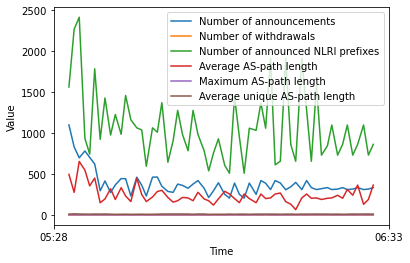

In [117]:
plot_day(synthetic_features[1,:,:])

In [118]:
synthetic_features.shape

(1000, 60, 37)

In [61]:
# synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=slammer_df_train.columns[1:])

# print("Correlation in real data:")
# print(slammer_df_train.corr())

# print("Correlation in synthetic data:")
# print(synthetic_df.corr())

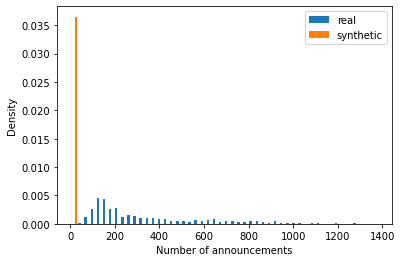

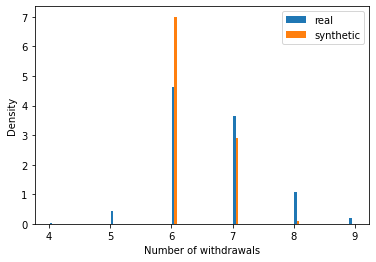

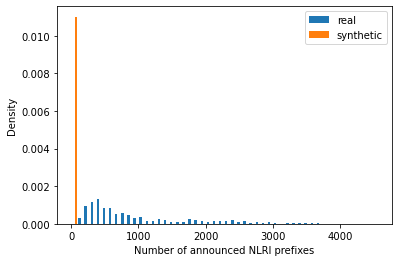

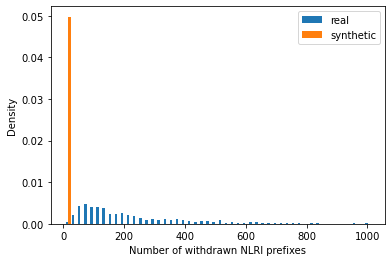

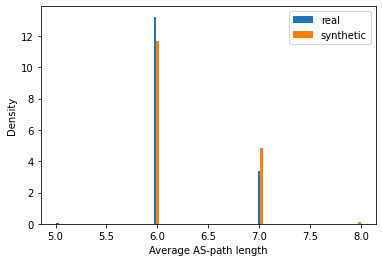

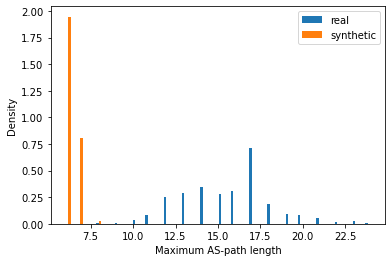

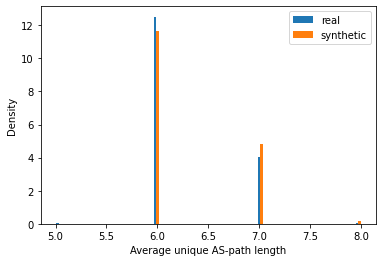

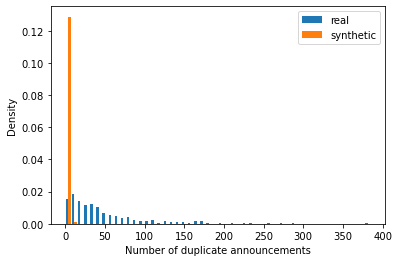

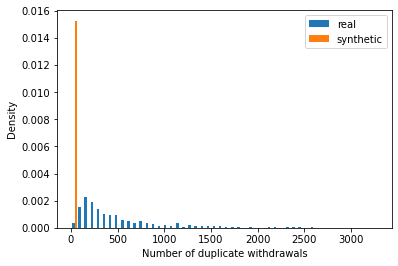

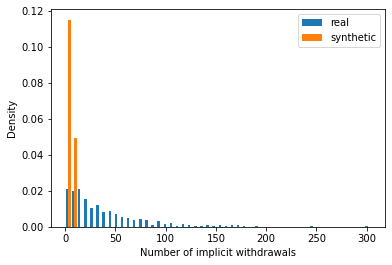

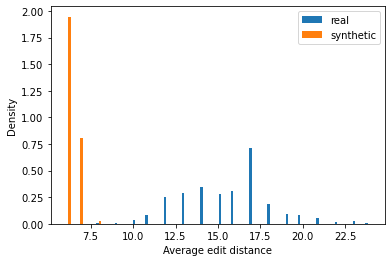

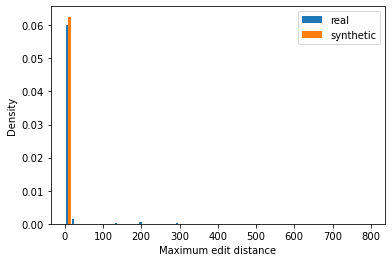

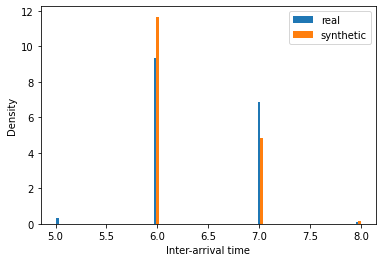

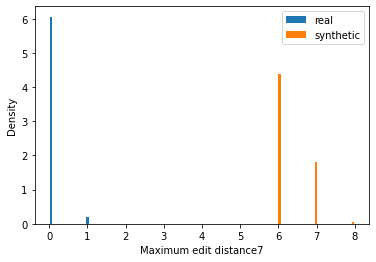

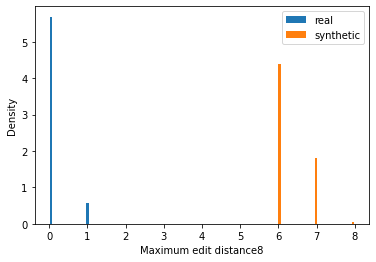

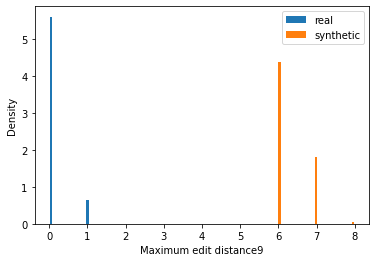

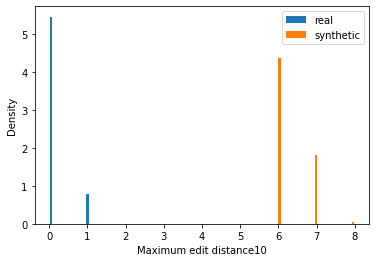

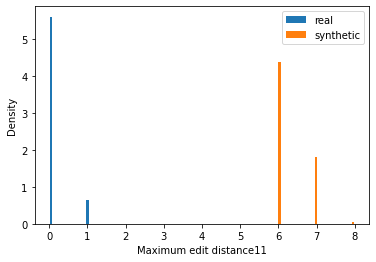

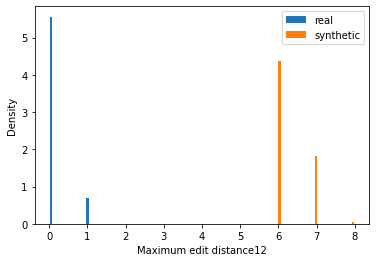

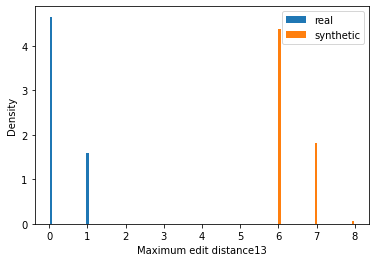

In [120]:
for i in range(0,20):
    plt.hist([features[:,:,i].flatten(), synthetic_features[:,:,1].flatten()], 
             label=["real", "synthetic"],
             bins=50,
             density=True)
    plt.legend()
    plt.xlabel(slammer_df_train.columns[i+1])
    plt.ylabel("Density")
    plt.show()